In [ ]:
# link to google drive
# from google.colab import drive
# drive.mount('/content/drive')

# **SECTION 1 - Setup (Reproducible)**

In [1]:
import os, re, random, time
import numpy as np
import pandas as pd

# Settiing Seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

CONFIG = {
    "seed": 42,
    "dataset_uri": "hf://datasets/mahfoos/Patient-Doctor-Conversation/pred_status.csv",
    "label_col": "Status",
    "text_cols": ["Description", "Patient"],
    "split": (0.70, 0.15, 0.15),
}

set_seed(CONFIG["seed"])
print("Seed =", CONFIG["seed"])

Seed = 42


# **SECTION 2 - Load + Prepare Data**

In [2]:
# Dowload Hugging Face Dataset
df = pd.read_csv(CONFIG["dataset_uri"])
print("Shape:", df.shape)
print("Columns:", list(df.columns))
display(df.head())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Shape: (3325, 4)
Columns: ['Description', 'Doctor', 'Patient', 'Status']


,Description,Doctor,Patient,Status
0,what does abutment of the nerve root mean,hi I have gone through your query with diligen...,hi doctor I am just wondering what is abutting...,medium severity
1,every time I eat spicy food I poop blood why,hello I have gone through your information and...,hi doctor I am a 26 year old male I am feet an...,high severity
2,will nano leo give permanent solution for erec...,hi for further doubts consult a sexologist online,hello doctor I am 48 years old I am experienci...,low severity
3,will kalarchikai cure multiple ovarian cysts i...,hello I just read your query see kalarachi kai...,hello doctor I have multiple small cysts in bo...,medium severity
4,I masturbate only by rubbing the tip of the pe...,hi for further doubts consult a sexologist online,hi doctor during masturbation I just rub the t...,low severity


In [3]:
# Check the column
need_cols = CONFIG["text_cols"] + [CONFIG["label_col"]]
missing = [c for c in need_cols if c not in df.columns]

if missing:
    print("Missing columns:", missing)
    print("Fix CONFIG['text_cols'] or CONFIG['label_col'] = dataset")
else:
    print("Columns OK")

Columns OK


In [ ]:
# merge text: Description + Patient
def merge_text(row):
    a = str(row[CONFIG["text_cols"][0]]) if pd.notna(row[CONFIG["text_cols"][0]]) else ""
    b = str(row[CONFIG["text_cols"][1]]) if pd.notna(row[CONFIG["text_cols"][1]]) else ""
    return (a + " " + b).strip()

df["text_raw"] = df.apply(merge_text, axis=1)
df["label_str"] = df[CONFIG["label_col"]].astype(str)

# map label to number (3 classes)
label_map = {
    "low severity": 0,
    "medium severity": 1,
    "high severity": 2
}

df = df[df["label_str"].isin(label_map)].copy()
df["label"] = df["label_str"].map(label_map)

print(df["label_str"].value_counts())
display(df[["text_raw", "label_str", "label"]].head())

label_str
medium severity    1779
low severity       1068
high severity       473
Name: count, dtype: int64


,text_raw,label_str,label
0,what does abutment of the nerve root mean hi d...,medium severity,1
1,every time I eat spicy food I poop blood why h...,high severity,2
2,will nano leo give permanent solution for erec...,low severity,0
3,will kalarchikai cure multiple ovarian cysts i...,medium severity,1
4,I masturbate only by rubbing the tip of the pe...,low severity,0


In [ ]:
# do cleaned version (haven't do stopword/lemma in this section yet)
def clean_text_simple(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    text = text.strip()
    return text

df["text_clean"] = df["text_raw"].apply(clean_text_simple)

In [ ]:
# Stratified split 70/15/15
from sklearn.model_selection import train_test_split

train_ratio, val_ratio, test_ratio = CONFIG["split"]

train_df, temp_df = train_test_split(
    df, test_size=(1-train_ratio),
    random_state=CONFIG["seed"],
    stratify=df["label"]
)

# split temp -> val/test
val_size = val_ratio / (val_ratio + test_ratio)
val_df, test_df = train_test_split(
    temp_df, test_size=(1-val_size),
    random_state=CONFIG["seed"],
    stratify=temp_df["label"]
)

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)

# check distribution that nearby or not?
def show_dist(d, name):
    print("\n", name)
    print(d["label_str"].value_counts(normalize=True))

show_dist(train_df, "Train dist")
show_dist(val_df, "Val dist")
show_dist(test_df, "Test dist")

Train: (2323, 8) Val: (498, 8) Test: (499, 8)

 Train dist
label_str
medium severity    0.535945
low severity       0.321567
high severity      0.142488
Name: proportion, dtype: float64

 Val dist
label_str
medium severity    0.536145
low severity       0.321285
high severity      0.142570
Name: proportion, dtype: float64

 Test dist
label_str
medium severity    0.535070
low severity       0.322645
high severity      0.142285
Name: proportion, dtype: float64


# **SECTION 3 - EDA**

3.1 imbalance ratio

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

counts = train_df["label_str"].value_counts()
imbalance_ratio = counts.max() / counts.min()
print("Label counts:\n", counts)
print("Imbalance ratio (max/min) =", round(imbalance_ratio, 3))

Label counts:
 label_str
medium severity    1245
low severity        747
high severity       331
Name: count, dtype: int64
Imbalance ratio (max/min) = 3.761


3.2 text length per class

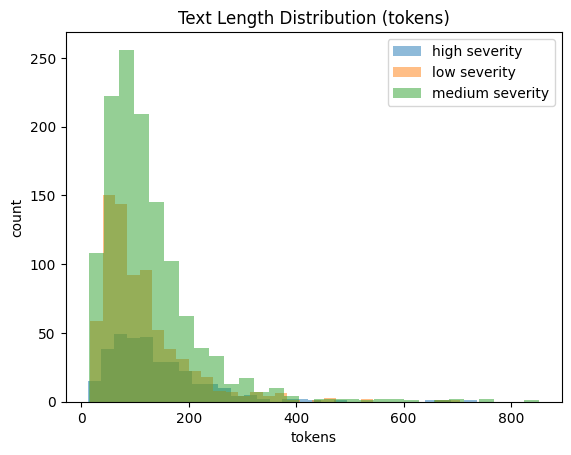

In [ ]:
def plot_length_dist(df_, text_col="text_raw"):
    plt.figure()
    for cls, g in df_.groupby("label_str"):
        lens = g[text_col].str.split().apply(len)
        plt.hist(lens, bins=30, alpha=0.5, label=cls)
    plt.title("Text Length Distribution (tokens)")
    plt.xlabel("tokens")
    plt.ylabel("count")
    plt.legend()
    plt.show()

plot_length_dist(train_df, "text_raw")

3.3 vocab size + TTR per class

In [ ]:
def vocab_stats(texts):
    tokens = [w for t in texts for w in t.lower().split()]
    vocab = set(tokens)
    ttr = len(vocab) / max(1, len(tokens))
    return len(vocab), ttr

rows = []
for cls, g in train_df.groupby("label_str"):
    vsize, ttr = vocab_stats(g["text_raw"])
    rows.append([cls, len(g), vsize, ttr])

eda_df = pd.DataFrame(rows, columns=["class", "num_docs", "vocab_size", "TTR"])
display(eda_df)

,class,num_docs,vocab_size,TTR
0,high severity,331,4852,0.105667
1,low severity,747,6143,0.072722
2,medium severity,1245,8385,0.054245


3.4 Top 20 words per class (remove stopwords, to understand meaning)

In [ ]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
STOP = set(stopwords.words("english"))

from collections import Counter
import re

def top_words_no_stop(texts, k=20):
    """Return top-k frequent non-stopword alphabetic tokens."""
    tokens = []
    for t in texts:
        # Extract lowercase alphabetic tokens only
        toks = re.findall(r"[a-z]+", str(t).lower())
        # Remove stopwords and very short tokens
        toks = [w for w in toks if w not in STOP and len(w) > 2]
        tokens.extend(toks)

    return Counter(tokens).most_common(k)


# Word frequency analysis per class (EDA)
for cls, g in train_df.groupby("label_str"):
    print("\n===", cls, "===")
    print(top_words_no_stop(g["text_raw"], 20))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



=== high severity ===
[('doctor', 426), ('pain', 226), ('hello', 188), ('please', 185), ('years', 182), ('also', 160), ('like', 150), ('help', 144), ('old', 141), ('blood', 129), ('days', 125), ('get', 122), ('months', 116), ('year', 110), ('back', 109), ('two', 105), ('day', 105), ('feel', 104), ('know', 99), ('test', 97)]

=== low severity ===
[('doctor', 821), ('hello', 401), ('please', 396), ('pain', 345), ('years', 299), ('old', 290), ('also', 283), ('help', 281), ('like', 278), ('get', 264), ('days', 254), ('months', 225), ('year', 223), ('last', 207), ('two', 205), ('day', 204), ('feel', 203), ('one', 197), ('time', 194), ('back', 185)]

=== medium severity ===
[('doctor', 1521), ('pain', 978), ('please', 726), ('hello', 715), ('years', 629), ('days', 603), ('also', 537), ('help', 526), ('old', 469), ('two', 464), ('back', 462), ('like', 439), ('get', 423), ('months', 417), ('last', 402), ('one', 376), ('day', 371), ('feel', 369), ('year', 356), ('normal', 348)]


3.5 PMI-like word score (regex-based tokenization)

In [ ]:
import re
import math
import pandas as pd
from collections import Counter
from google.colab import files

def tokenize_simple(text):
    # Extract lowercase alphabetic tokens; remove very short tokens
    toks = re.findall(r"[a-z]+", str(text).lower())
    return [w for w in toks if len(w) > 2]

def pmi_like_clean(df_, target_cls, text_col="text_raw", min_freq=5, top_k=20):
    """PMI-like score per token: log(P(w|class) / P(w)) with a minimum global frequency filter."""
    cls_texts = df_[df_["label_str"] == target_cls][text_col]
    rest_texts = df_[df_["label_str"] != target_cls][text_col]

    cls_tokens = [w for t in cls_texts for w in tokenize_simple(t)]
    rest_tokens = [w for t in rest_texts for w in tokenize_simple(t)]
    all_tokens = cls_tokens + rest_tokens

    c_cls = Counter(cls_tokens)
    c_all = Counter(all_tokens)

    N_cls = len(cls_tokens)
    N_all = len(all_tokens)

    scores = []
    for w, f in c_cls.items():
        if c_all[w] < min_freq:
            continue
        p_w_cls = f / N_cls
        p_w = c_all[w] / N_all
        score = math.log(p_w_cls / p_w)
        scores.append((w, score, f, c_all[w]))

    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:top_k]

all_rows = []

for cls in sorted(train_df["label_str"].unique()):
    # Compute top PMI-like tokens for this class
    results = pmi_like_clean(train_df, cls, top_k=20)
    for w, s, f_cls, f_all in results:
        all_rows.append({
            "class": cls,
            "word": w,
            "pmi_like_score": round(s, 6),
            "freq_in_class": f_cls,
            "freq_in_all": f_all
        })

pmi_df = pd.DataFrame(all_rows)

# file_path = "/content/pmi_like_words.csv"
# pmi_df.to_csv(file_path, index=False)

# print("Saved to:", file_path)
# print("Shape:", pmi_df.shape)

# # Download automatically
# files.download(file_path)

pmi_df

,class,word,pmi_like_score,freq_in_class,freq_in_all
0,high severity,map,1.816012,5,5
1,high severity,thecar,1.816012,5,5
2,high severity,torsion,1.816012,5,5
3,high severity,infact,1.816012,7,7
4,high severity,mercury,1.816012,7,7
5,high severity,dysplasia,1.816012,5,5
6,high severity,bitten,1.816012,6,6
7,high severity,heroin,1.816012,5,5
8,high severity,fasciculations,1.816012,7,7
9,high severity,downs,1.816012,5,5


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# ---- 1) Text length stats ----
def token_len(s):
    # Simple whitespace token count for quick length distribution checks
    return len(str(s).split())

def describe_len(s):
    # Summarize token-length distribution using common percentiles and dispersion stats
    d = s.describe(percentiles=[0.25,0.5,0.75])
    return {
        "count": int(d["count"]),
        "min": int(d["min"]),
        "p25": float(d["25%"]),
        "median": float(d["50%"]),
        "mean": float(d["mean"]),
        "p75": float(d["75%"]),
        "max": int(d["max"]),
        "std": float(d["std"]),
    }

train_lens = train_df["text_raw"].apply(token_len)
val_lens   = val_df["text_raw"].apply(token_len)
test_lens  = test_df["text_raw"].apply(token_len)

print("Overall length stats (tokens)")
print("Train:", describe_len(train_lens))
print("Val  :", describe_len(val_lens))
print("Test :", describe_len(test_lens))

# ---- 2) TF-IDF tuned vocab + sparsity ----
def tfidf_stats(texts, ngram_range, min_df):
    # Fit TF-IDF with specified n-gram range and minimum document frequency
    vec = TfidfVectorizer(lowercase=False, ngram_range=ngram_range, min_df=min_df)
    X = vec.fit_transform(texts)
    vocab_size = len(vec.vocabulary_)
    # Sparsity = percentage of zero entries in the TF-IDF matrix
    sparsity = 100 * (1 - X.count_nonzero() / (X.shape[0]*X.shape[1]))
    return vocab_size, sparsity, X.shape

v_lr, sp_lr, sh_lr = tfidf_stats(train_df["text_raw"], (1,3), 1)
v_nb, sp_nb, sh_nb = tfidf_stats(train_df["text_raw"], (1,1), 2)

print("\nTF-IDF tuned stats")
print("LR tuned (1,3), min_df=1:", "vocab=", v_lr, "sparsity%=", sp_lr, "shape=", sh_lr)
print("NB tuned (1,1), min_df=2:", "vocab=", v_nb, "sparsity%=", sp_nb, "shape=", sh_nb)

# ---- 3) Confusion matrices (Test) ----
# Use y_true = test_df["label"].values and each model's y_pred (e.g., lr_test_pred, etc.)
LABELS = [0,1,2]  # low, medium, high

def report_test(y_true, y_pred, name):
    # Standard multi-class metrics (macro averages to treat classes equally)
    acc = accuracy_score(y_true,y_pred)
    mp  = precision_score(y_true,y_pred,average="macro",zero_division=0)
    mr  = recall_score(y_true,y_pred,average="macro",zero_division=0)
    mf1 = f1_score(y_true,y_pred,average="macro")
    cm  = confusion_matrix(y_true,y_pred,labels=LABELS)
    print(f"\n{name}")
    print("Acc/MacroP/MacroR/MacroF1:", acc, mp, mr, mf1)
    print("CM (rows=true, cols=pred):\n", cm)

# Example usage:
# y_true = test_df["label"].values
# report_test(y_true, lr_test_pred,  "LR")
# report_test(y_true, svm_test_pred, "SVM")
# report_test(y_true, nb_test_pred,  "NB")
# report_test(y_true, fnn_test_pred, "FNN")
# report_test(y_true, bert_test_pred,"BERT")

Overall length stats (tokens)
Train: {'count': 2323, 'min': 13, 'p25': 65.0, 'median': 101.0, 'mean': 122.6719758932415, 'p75': 153.0, 'max': 852, 'std': 88.82532783769511}
Val  : {'count': 498, 'min': 17, 'p25': 63.25, 'median': 98.0, 'mean': 116.58232931726907, 'p75': 151.0, 'max': 619, 'std': 77.34332673305951}
Test : {'count': 499, 'min': 17, 'p25': 66.0, 'median': 104.0, 'mean': 128.32264529058116, 'p75': 159.0, 'max': 1003, 'std': 97.79507972639117}

TF-IDF tuned stats
LR tuned (1,3), min_df=1: vocab= 318081 sparsity%= 99.91002286455615 shape= (2323, 318081)
NB tuned (1,1), min_df=2: vocab= 6079 sparsity%= 98.83662640493935 shape= (2323, 6079)


# **SECTION 4 - Preprocessing Ablation + Macro-F1**

In [ ]:
# Optional:
# !pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl

In [ ]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
STOP = set(stopwords.words("english"))

# spaCy for lemmatization
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Preprocess function
def preprocess_full(text, lower=False, rm_punct=False, rm_stop=False, lemma=False):
    t = str(text)

    if lower:
        t = t.lower()

    if rm_punct:
        t = re.sub(r"[^\w\s]", " ", t)

    t = re.sub(r"\s+", " ", t).strip()

    tokens = t.split()

    if rm_stop:
        tokens = [w for w in tokens if w not in STOP]

    if lemma:
        doc = nlp(" ".join(tokens))
        tokens = [tok.lemma_ for tok in doc]

    return " ".join(tokens)

# Ablation Configurations
ABLATIONS = [
    {"name": "A_raw","lower": False, "punct": False,"stop": False, "lemma": False},
    {"name": "B_clean", "lower": True,  "punct": True, "stop": False, "lemma": False},
    {"name": "C_stop", "lower": True,  "punct": True, "stop": True, "lemma": False},
    {"name": "D_stop_lemma","lower": True,"punct": True,"stop": True,"lemma": True},
]

results = []

for exp in ABLATIONS:
    print("\nRunning:", exp["name"])

    X_train = train_df["text_raw"].apply(
        lambda x: preprocess_full(
            x,
            lower=exp["lower"],
            rm_punct=exp["punct"],
            rm_stop=exp["stop"],
            lemma=exp["lemma"]
        )
    )

    X_val = val_df["text_raw"].apply(
        lambda x: preprocess_full(
            x,
            lower=exp["lower"],
            rm_punct=exp["punct"],
            rm_stop=exp["stop"],
            lemma=exp["lemma"]
        )
    )

    y_train = train_df["label"].values
    y_val   = val_df["label"].values

    vec = TfidfVectorizer(
        lowercase=False,
        ngram_range=(1,2),
        min_df=2
    )

    Xtr = vec.fit_transform(X_train)
    Xva = vec.transform(X_val)

    # Logistic Regression baseline
    clf = LogisticRegression(max_iter=300, class_weight="balanced")
    clf.fit(Xtr, y_train)
    pred = clf.predict(Xva)

    macro_f1 = f1_score(y_val, pred, average="macro")

    vocab_size = len(vec.vocabulary_)

    results.append([
        exp["name"],
        macro_f1,
        vocab_size
    ])

# Result Table
ablation_df = pd.DataFrame(
    results,
    columns=["experiment", "macro_f1", "vocab_size"]
).sort_values("macro_f1", ascending=False)

display(ablation_df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Running: A_raw

Running: B_clean

Running: C_stop

Running: D_stop_lemma


,experiment,macro_f1,vocab_size
0,A_raw,0.479090,31660
1,B_clean,0.479090,31660
3,D_stop_lemma,0.468989,18699
2,C_stop,0.462282,18137


In [ ]:
base_vocab = 31660
ablation_df["vocab_reduction_%"] = (
    (base_vocab - ablation_df["vocab_size"]) / base_vocab * 100
)
display(ablation_df)

,experiment,macro_f1,vocab_size,vocab_reduction_%
0,A_raw,0.479090,31660,0.000000
1,B_clean,0.479090,31660,0.000000
3,D_stop_lemma,0.468989,18699,40.938092
2,C_stop,0.462282,18137,42.713203


# **SECTION 5 - Feature Representations**

5.1 TF-IDF (1–2 grams)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

print("TF-IDF (1-2 grams)")

tfidf_12 = TfidfVectorizer(
    lowercase=False,
    ngram_range=(1,2),
    min_df=2
)

X_train_12 = tfidf_12.fit_transform(train_df["text_raw"])
X_val_12   = tfidf_12.transform(val_df["text_raw"])

print("Shape:", X_train_12.shape)
print("Vocab size:", len(tfidf_12.vocabulary_))
print("Sparsity:", 100 * (1 - X_train_12.count_nonzero() / (X_train_12.shape[0] * X_train_12.shape[1])), "%")

TF-IDF (1-2 grams)
Shape: (2323, 31660)
Vocab size: 31660
Sparsity: 99.55588991841589 %


5.2 TF-IDF (1–3 grams)

In [ ]:
print("\nTF-IDF (1-3 grams)")

tfidf_13 = TfidfVectorizer(
    lowercase=False,
    ngram_range=(1,3),
    min_df=2
)

X_train_13 = tfidf_13.fit_transform(train_df["text_raw"])
X_val_13   = tfidf_13.transform(val_df["text_raw"])

print("Shape:", X_train_13.shape)
print("Vocab size:", len(tfidf_13.vocabulary_))
print("Sparsity:", 100 * (1 - X_train_13.count_nonzero() / (X_train_13.shape[0] * X_train_13.shape[1])), "%")


TF-IDF (1-3 grams)
Shape: (2323, 50113)
Vocab size: 50113
Sparsity: 99.65907870425494 %


5.3 GloVe Embeddings (Static Embedding)

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 43.5 MB/s eta 0:00:00


In [ ]:
import gensim.downloader as api

print("Loading GloVe...")
glove = api.load("glove-wiki-gigaword-100") # 100-dim

def glove_vector(text):
    tokens = text.lower().split()
    vectors = [glove[w] for w in tokens if w in glove]

    if len(vectors) == 0:
        return np.zeros(100)

    return np.mean(vectors, axis=0)

print("Building GloVe features...")

X_train_glove = np.vstack(train_df["text_raw"].apply(glove_vector))
X_val_glove   = np.vstack(val_df["text_raw"].apply(glove_vector))

print("Shape:", X_train_glove.shape)

Loading GloVe...
[==================================================] 100.0% 128.1/128.1MB downloaded
Building GloVe features...
Shape: (2323, 100)


5.4 BERT Tokenizer Representation (Contextual Input)

In [ ]:
from transformers import AutoTokenizer, EarlyStoppingCallback
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def bert_token_length(text):
    return len(tokenizer.encode(text, truncation=True, max_length=512))

train_lengths = train_df["text_raw"].apply(bert_token_length)

print("Average BERT token length:", np.mean(train_lengths))
print("Max BERT token length:", np.max(train_lengths))

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Average BERT token length: 135.39345673697804
Max BERT token length: 512


comparison

In [ ]:
feature_summary = pd.DataFrame([
    ["TF-IDF (1-2)", X_train_12.shape[1], "Sparse", "High"],
    ["TF-IDF (1-3)", X_train_13.shape[1], "Very Sparse", "Very High"],
    ["GloVe (100d)", X_train_glove.shape[1], "Dense", "Low"],
    ["BERT Input", "Variable", "Dense", "Very High"],
], columns=["Representation", "Dimensionality", "Sparsity", "Memory Cost"])

display(feature_summary)

,Representation,Dimensionality,Sparsity,Memory Cost
0,TF-IDF (1-2),31660,Sparse,High
1,TF-IDF (1-3),50113,Very Sparse,Very High
2,GloVe (100d),100,Dense,Low
3,BERT Input,Variable,Dense,Very High


# **SECTION 6 - Models (Minimum 5)**

Helper: Evaluation Function

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(name, y_true, y_pred):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro_F1": f1_score(y_true, y_pred, average="macro"),
        "Macro_Precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "Macro_Recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
    }

6.1 Logistic Regression (TF-IDF 1-2)

In [ ]:
from sklearn.linear_model import LogisticRegression

print("Training Logistic Regression...")

lr = LogisticRegression(max_iter=500, class_weight="balanced")
lr.fit(X_train_12, train_df["label"])

pred_lr = lr.predict(X_val_12)

res_lr = evaluate_model("Logistic Regression", val_df["label"], pred_lr)
res_lr

Training Logistic Regression...


{'Model': 'Logistic Regression',
 'Accuracy': 0.5401606425702812,
 'Macro_F1': 0.47909029127748015,
 'Macro_Precision': 0.4772002515795168,
 'Macro_Recall': 0.48167519473897064}

6.2 Linear SVM (TF-IDF 1-2)

In [ ]:
from sklearn.svm import LinearSVC

print("Training Linear SVM...")

svm = LinearSVC(class_weight="balanced")
svm.fit(X_train_12, train_df["label"])

pred_svm = svm.predict(X_val_12)

res_svm = evaluate_model("Linear SVM", val_df["label"], pred_svm)
res_svm

Training Linear SVM...


{'Model': 'Linear SVM',
 'Accuracy': 0.5341365461847389,
 'Macro_F1': 0.40589061971089396,
 'Macro_Precision': 0.424306689651001,
 'Macro_Recall': 0.40870116140036217}

6.3 Multinomial Naive Bayes (TF-IDF 1-2)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

print("Training Multinomial NB...")

nb = MultinomialNB()
nb.fit(X_train_12, train_df["label"])

pred_nb = nb.predict(X_val_12)

res_nb = evaluate_model("Multinomial NB", val_df["label"], pred_nb)
res_nb

Training Multinomial NB...


{'Model': 'Multinomial NB',
 'Accuracy': 0.536144578313253,
 'Macro_F1': 0.23267973856209148,
 'Macro_Precision': 0.178714859437751,
 'Macro_Recall': 0.3333333333333333}

6.4 FNN (GloVe mean)

In [ ]:
from sklearn.metrics import f1_score
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# numpy -> torch tensor
X_train_tensor = torch.tensor(X_train_glove, dtype=torch.float32)
y_train_tensor = torch.tensor(train_df["label"].values, dtype=torch.long)

X_val_tensor = torch.tensor(X_val_glove, dtype=torch.float32)
y_val_tensor = torch.tensor(val_df["label"].values, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32, shuffle=False)

# Simple FNN model (2 layers + dropout)
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=128, num_classes=3, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self, x):
        return self.net(x)

model = MLPClassifier(input_dim=100, hidden_dim=128, num_classes=3, dropout=0.3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# train
EPOCHS = 10
from sklearn.metrics import f1_score

def eval_fnn(model, loader):
    model.eval()
    preds_all, y_all = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            preds_all.extend(preds)
            y_all.extend(yb.numpy())
    return f1_score(y_all, preds_all, average="macro")

for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    val_f1 = eval_fnn(model, val_loader)
    print(f"Epoch {epoch}: train_loss={total_loss/len(train_loader):.4f}  val_macro_f1={val_f1:.4f}")

model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in val_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())

res_fnn = evaluate_model("FNN (GloVe mean)", val_df["label"], all_preds)
res_fnn

Device: cuda
Epoch 1: train_loss=0.9910  val_macro_f1=0.2327
Epoch 2: train_loss=0.9673  val_macro_f1=0.2327
Epoch 3: train_loss=0.9506  val_macro_f1=0.2527
Epoch 4: train_loss=0.9394  val_macro_f1=0.3512
Epoch 5: train_loss=0.9351  val_macro_f1=0.2733
Epoch 6: train_loss=0.9317  val_macro_f1=0.3943
Epoch 7: train_loss=0.9241  val_macro_f1=0.3547
Epoch 8: train_loss=0.9157  val_macro_f1=0.3604
Epoch 9: train_loss=0.9187  val_macro_f1=0.3629
Epoch 10: train_loss=0.9115  val_macro_f1=0.3370


{'Model': 'FNN (GloVe mean)',
 'Accuracy': 0.5642570281124498,
 'Macro_F1': 0.3370347227646298,
 'Macro_Precision': 0.3855273103393404,
 'Macro_Recall': 0.37919787765293383}

6.5 BERT Fine-Tuning

In [ ]:
!pip install transformers datasets accelerate -q

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text_raw"], truncation=True, padding=True)

train_ds = Dataset.from_pandas(train_df[["text_raw","label"]])
val_ds   = Dataset.from_pandas(val_df[["text_raw","label"]])

train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids","attention_mask","label"])
val_ds.set_format("torch", columns=["input_ids","attention_mask","label"])




Map:   0%|          | 0/2323 [00:00<?, ? examples/s]

Map:   0%|          | 0/498 [00:00<?, ? examples/s]

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro"),
        "macro_precision": precision_score(labels, preds, average="macro", zero_division=0),
        "macro_recall": recall_score(labels, preds, average="macro", zero_division=0),
    }

In [ ]:
model_bert = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3
)

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab_Notebooks/pj_nlp/bert_results65",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    logging_steps=100,
    report_to="none",
    learning_rate=3e-5
)

trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

predictions = trainer.predict(val_ds)
preds_bert = np.argmax(predictions.predictions, axis=1)

res_bert = evaluate_model("BERT", val_df["label"], preds_bert)
res_bert

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,0.975340,0.943602,0.536145,0.232680,0.178715,0.333333
2,0.949892,0.871589,0.608434,0.418427,0.402697,0.446738
3,0.818527,0.857538,0.586345,0.403512,0.384053,0.432171
4,0.672729,0.951379,0.566265,0.484269,0.526513,0.479858
5,0.484540,1.090267,0.578313,0.505512,0.528295,0.494542
6,0.320616,1.290881,0.598394,0.482344,0.539543,0.475067
7,0.189999,1.752618,0.600402,0.486153,0.549712,0.476422


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

{'Model': 'BERT',
 'Accuracy': 0.5783132530120482,
 'Macro_F1': 0.5055117807439539,
 'Macro_Precision': 0.5282949095903681,
 'Macro_Recall': 0.49454192382760986}

In [ ]:
results_df = pd.DataFrame([
    res_lr,
    res_svm,
    res_nb,
    res_fnn,
    res_bert
])
results_df.sort_values("Macro_F1", ascending=False)

,Model,Accuracy,Macro_F1,Macro_Precision,Macro_Recall
4,BERT,0.578313,0.505512,0.528295,0.494542
0,Logistic Regression,0.540161,0.479090,0.477200,0.481675
1,Linear SVM,0.534137,0.405891,0.424307,0.408701
3,FNN (GloVe mean),0.564257,0.337035,0.385527,0.379198
2,Multinomial NB,0.536145,0.232680,0.178715,0.333333


# **SECTION 7 - Hyperparameter Tuning**

7.1 Scorer + Helper

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score
import pandas as pd

macro_f1_scorer = make_scorer(f1_score, average="macro")

X_train_text = train_df["text_raw"]
y_train = train_df["label"]

X_val_text = val_df["text_raw"]
y_val = val_df["label"]

print("Train size:", len(X_train_text), "Val size:", len(X_val_text))

Train size: 2323 Val size: 498


7.2 ML Grid Search (Logistic Regression + Linear SVM + NB)

*   7.2.1 Logistic Regression (TF-IDF + LR)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=False)),
    ("clf", LogisticRegression(max_iter=800, class_weight="balanced"))
])

param_grid_lr = {
    "tfidf__ngram_range": [(1,2), (1,3)],
    "tfidf__min_df": [1, 2],
    "clf__C": [0.1, 1, 10],
}

gs_lr = GridSearchCV(
    pipe_lr,
    param_grid_lr,
    scoring=macro_f1_scorer,
    cv=3,
    n_jobs=-1,
    verbose=1
)

gs_lr.fit(X_train_text, y_train)

print("Best LR params:", gs_lr.best_params_)
print("Best CV Macro-F1:", gs_lr.best_score_)

best_lr = gs_lr.best_estimator_
pred_lr_val = best_lr.predict(X_val_text)
res_lr_tuned = evaluate_model("LR (tuned)", y_val, pred_lr_val)
res_lr_tuned

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best LR params: {'clf__C': 0.1, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 3)}
Best CV Macro-F1: 0.4523897105046994


{'Model': 'LR (tuned)',
 'Accuracy': 0.5220883534136547,
 'Macro_F1': 0.4766869535001151,
 'Macro_Precision': 0.47726133192289,
 'Macro_Recall': 0.48788486223206906}

* 7.2.2 Linear SVM (TF-IDF + LinearSVC)




In [ ]:
from sklearn.svm import LinearSVC

pipe_svm = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=False)),
    ("clf", LinearSVC(class_weight="balanced"))
])

param_grid_svm = {
    "tfidf__ngram_range": [(1,2), (1,3)],
    "tfidf__min_df": [1, 2],
    "clf__C": [0.1, 1, 10],
}

gs_svm = GridSearchCV(
    pipe_svm,
    param_grid_svm,
    scoring=macro_f1_scorer,
    cv=3,
    n_jobs=-1,
    verbose=1
)

gs_svm.fit(X_train_text, y_train)

print("Best SVM params:", gs_svm.best_params_)
print("Best CV Macro-F1:", gs_svm.best_score_)

best_svm = gs_svm.best_estimator_
pred_svm_val = best_svm.predict(X_val_text)
res_svm_tuned = evaluate_model("Linear SVM (tuned)", y_val, pred_svm_val)
res_svm_tuned

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best SVM params: {'clf__C': 0.1, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Best CV Macro-F1: 0.4093107688771879


{'Model': 'Linear SVM (tuned)',
 'Accuracy': 0.572289156626506,
 'Macro_F1': 0.4365891140726505,
 'Macro_Precision': 0.49706058955776183,
 'Macro_Recall': 0.43513983401030404}

* 7.2.3 Multinomial Naive Bayes (TF-IDF + NB)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

pipe_nb = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=False)),
    ("clf", MultinomialNB())
])

param_grid_nb = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2],
    "clf__alpha": [0.1, 0.5, 1.0],
}

gs_nb = GridSearchCV(
    pipe_nb,
    param_grid_nb,
    scoring=macro_f1_scorer,
    cv=3,
    n_jobs=-1,
    verbose=1
)

gs_nb.fit(X_train_text, y_train)

print("Best NB params:", gs_nb.best_params_)
print("Best CV Macro-F1:", gs_nb.best_score_)

best_nb = gs_nb.best_estimator_
pred_nb_val = best_nb.predict(X_val_text)
res_nb_tuned = evaluate_model("Multinomial NB (tuned)", y_val, pred_nb_val)
res_nb_tuned

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best NB params: {'clf__alpha': 0.1, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}
Best CV Macro-F1: 0.3581382472574624


{'Model': 'Multinomial NB (tuned)',
 'Accuracy': 0.6004016064257028,
 'Macro_F1': 0.41614044351264085,
 'Macro_Precision': 0.5759535655058042,
 'Macro_Recall': 0.43121153575636084}

7.3 สรุปผล ML tuning เป็นตารางเดียว

In [ ]:
tuned_ml_df = pd.DataFrame([res_lr_tuned, res_svm_tuned, res_nb_tuned])
tuned_ml_df.sort_values("Macro_F1", ascending=False)

,Model,Accuracy,Macro_F1,Macro_Precision,Macro_Recall
0,LR (tuned),0.522088,0.476687,0.477261,0.487885
1,Linear SVM (tuned),0.572289,0.436589,0.497061,0.435140
2,Multinomial NB (tuned),0.600402,0.416140,0.575954,0.431212


7.4 FNN Hyperarmeter Tuning

* 7.4.1 Reusable Function

In [ ]:
def train_eval_fnn_once(
    hidden_dim=128,
    dropout=0.3,
    lr=1e-3,
    batch_size=32,
    epochs=10
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = DataLoader(
        TensorDataset(X_train_tensor, y_train_tensor),
        batch_size=batch_size, shuffle=True
    )
    val_loader = DataLoader(
        TensorDataset(X_val_tensor, y_val_tensor),
        batch_size=batch_size, shuffle=False
    )

    model = MLPClassifier(
        input_dim=X_train_tensor.shape[1],
        hidden_dim=hidden_dim,
        num_classes=3,
        dropout=dropout
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_f1 = -1.0

    for epoch in range(1, epochs + 1):
        model.train()

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

        # validation
        model.eval()
        preds_all, y_all = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                logits = model(xb)
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                preds_all.extend(preds)
                y_all.extend(yb.numpy())

        val_f1 = f1_score(y_all, preds_all, average="macro")

        if val_f1 > best_f1:
            best_f1 = val_f1

    return float(best_f1)

* 7.4.2 FNN Hyperparameter Tuning

In [ ]:
import itertools
import pandas as pd

fnn_grid = {
    "hidden_dim": [64, 128, 256],
    "dropout": [0.2, 0.3, 0.5],
    "lr": [1e-3, 5e-4],
    "batch_size": [32, 64],
}

fnn_results = []

for hidden_dim, dropout, lr, batch_size in itertools.product(
    fnn_grid["hidden_dim"],
    fnn_grid["dropout"],
    fnn_grid["lr"],
    fnn_grid["batch_size"],
):
    print(f"[FNN GRID] hidden={hidden_dim}, dropout={dropout}, lr={lr}, bs={batch_size}")

    best_f1 = train_eval_fnn_once(
        hidden_dim=hidden_dim,
        dropout=dropout,
        lr=lr,
        batch_size=batch_size,
        epochs=10
    )

    fnn_results.append({
        "hidden_dim": hidden_dim,
        "dropout": dropout,
        "lr": lr,
        "batch_size": batch_size,
        "val_macro_f1": best_f1
    })

fnn_tune_df = pd.DataFrame(fnn_results).sort_values("val_macro_f1", ascending=False)

display(fnn_tune_df.head(10))

BEST_FNN_CONFIG = fnn_tune_df.iloc[0].to_dict()
print("BEST_FNN_CONFIG:", BEST_FNN_CONFIG)

[FNN GRID] hidden=64, dropout=0.2, lr=0.001, bs=32
[FNN GRID] hidden=64, dropout=0.2, lr=0.001, bs=64
[FNN GRID] hidden=64, dropout=0.2, lr=0.0005, bs=32
[FNN GRID] hidden=64, dropout=0.2, lr=0.0005, bs=64
[FNN GRID] hidden=64, dropout=0.3, lr=0.001, bs=32
[FNN GRID] hidden=64, dropout=0.3, lr=0.001, bs=64
[FNN GRID] hidden=64, dropout=0.3, lr=0.0005, bs=32
[FNN GRID] hidden=64, dropout=0.3, lr=0.0005, bs=64
[FNN GRID] hidden=64, dropout=0.5, lr=0.001, bs=32
[FNN GRID] hidden=64, dropout=0.5, lr=0.001, bs=64
[FNN GRID] hidden=64, dropout=0.5, lr=0.0005, bs=32
[FNN GRID] hidden=64, dropout=0.5, lr=0.0005, bs=64
[FNN GRID] hidden=128, dropout=0.2, lr=0.001, bs=32
[FNN GRID] hidden=128, dropout=0.2, lr=0.001, bs=64
[FNN GRID] hidden=128, dropout=0.2, lr=0.0005, bs=32
[FNN GRID] hidden=128, dropout=0.2, lr=0.0005, bs=64
[FNN GRID] hidden=128, dropout=0.3, lr=0.001, bs=32
[FNN GRID] hidden=128, dropout=0.3, lr=0.001, bs=64
[FNN GRID] hidden=128, dropout=0.3, lr=0.0005, bs=32
[FNN GRID] hidd

,hidden_dim,dropout,lr,batch_size,val_macro_f1
24,256,0.2,0.0010,32,0.410495
26,256,0.2,0.0005,32,0.394257
0,64,0.2,0.0010,32,0.393754
16,128,0.3,0.0010,32,0.391036
12,128,0.2,0.0010,32,0.390740
28,256,0.3,0.0010,32,0.389589
25,256,0.2,0.0010,64,0.388741
33,256,0.5,0.0010,64,0.385022
32,256,0.5,0.0010,32,0.382029
17,128,0.3,0.0010,64,0.380435


BEST_FNN_CONFIG: {'hidden_dim': 256.0, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32.0, 'val_macro_f1': 0.41049527279035475}


7.5 BERT Hyperparameter Tuning

*   7.5.1 BERT function (single hyperparameter configuration)


In [ ]:
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

def run_bert_once(lr, batch_size, epochs, seed=42, patience=2):
    """
    epochs = max_epochs (upper limit) -> EarlyStopping will stop training if no improvement
    patience = number of evaluation steps with no metric improvement before stopping
    """

    model = AutoModelForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=3
    )

    args = TrainingArguments(
        output_dir=f"./bert_tune/lr{lr}_bs{batch_size}_ep{epochs}_seed{seed}",

        num_train_epochs=epochs,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,

        eval_strategy="epoch",
        save_strategy="epoch",

        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        greater_is_better=True,

        logging_steps=50,
        seed=seed,
        report_to="none",
        fp16=True,

        save_total_limit=2
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=patience)]
    )

    trainer.train()
    eval_metrics = trainer.evaluate(val_ds)
    return eval_metrics

* 7.5.2 Iterate over the full hyperparameter grid and summarize results in a table

In [ ]:
bert_grid = []
for lr in [2e-5, 3e-5]:
    for bs in [8, 16]:
        for ep in [10]:
            print("\nRunning BERT:", "lr", lr, "bs", bs, "ep", ep)
            metrics = run_bert_once(lr, bs, ep, seed=CONFIG["seed"])
            bert_grid.append({
                "lr": lr,
                "batch_size": bs,
                "epochs": ep,
                "val_macro_f1": metrics.get("eval_macro_f1"),
                "val_accuracy": metrics.get("eval_accuracy"),
                "val_loss": metrics.get("eval_loss"),
            })

bert_tune_df = pd.DataFrame(bert_grid).sort_values("val_macro_f1", ascending=False)
bert_tune_df


Running BERT: lr 2e-05 bs 8 ep 10


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,1.004000,0.959792,0.554217,0.302166,0.374781,0.361267
2,0.898016,0.830689,0.610442,0.425825,0.400683,0.457171
3,0.743381,0.879521,0.616466,0.510970,0.558066,0.513854
4,0.503918,1.093303,0.590361,0.510106,0.528081,0.500877
5,0.283625,1.692486,0.620482,0.475531,0.563187,0.485654


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La


Running BERT: lr 2e-05 bs 16 ep 10


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,0.950570,0.896735,0.600402,0.381568,0.425207,0.414193
2,0.826759,0.850904,0.614458,0.494920,0.631226,0.492355
3,0.695368,0.870613,0.608434,0.483146,0.569589,0.478591
4,0.471599,1.075481,0.592369,0.500130,0.546967,0.487204
5,0.304670,1.183955,0.608434,0.470377,0.537112,0.470863
6,0.186156,1.458685,0.604418,0.451727,0.517266,0.457299


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La


Running BERT: lr 3e-05 bs 8 ep 10


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,0.995159,0.935302,0.580321,0.345883,0.420602,0.389185
2,0.927814,0.891149,0.574297,0.357528,0.391573,0.392954
3,0.758825,0.893713,0.604418,0.472621,0.596225,0.482453
4,0.656774,1.149013,0.526104,0.471091,0.512183,0.486013
5,0.468271,1.464940,0.576305,0.442389,0.602561,0.467266


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La


Running BERT: lr 3e-05 bs 16 ep 10


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,0.941371,0.898496,0.604418,0.420420,0.396736,0.450921
2,0.834128,0.849442,0.592369,0.500898,0.522468,0.491893
3,0.674655,0.913372,0.620482,0.479218,0.550070,0.494838
4,0.372556,1.130385,0.622490,0.513764,0.564153,0.501329
5,0.190082,1.484329,0.582329,0.519818,0.531653,0.525318
6,0.085835,1.905367,0.600402,0.512037,0.533280,0.505236
7,0.047988,2.244231,0.612450,0.516151,0.564766,0.502087


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

,lr,batch_size,epochs,val_macro_f1,val_accuracy,val_loss
3,0.00003,16,10,0.518154,0.580321,1.484953
0,0.00002,8,10,0.506041,0.616466,0.880834
1,0.00002,16,10,0.498468,0.590361,1.075962
2,0.00003,8,10,0.472621,0.604418,0.894638


* 7.5.3 Best config + Conclusion

In [ ]:
best_bert_row = bert_tune_df.iloc[0]
print("Best BERT config:", best_bert_row.to_dict())

Best BERT config: {'lr': 3e-05, 'batch_size': 16.0, 'epochs': 10.0, 'val_macro_f1': 0.5181535676088059, 'val_accuracy': 0.5803212851405622, 'val_loss': 1.4849528074264526}


# **SECTION 8 - Statistical Robustness**

8.1 Seeds

In [ ]:
import time
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel
from sklearn.metrics import f1_score

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

SEEDS = [42, 123, 2026, 4539, 832]
print("Seeds:", SEEDS)

def set_all_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

Seeds: [42, 123, 2026, 4539, 832]


8.2 Helper: make stratified 70/15/15 split per seed

In [ ]:
def make_split(df_all: pd.DataFrame, seed: int, label_col="label", split=(0.70, 0.15, 0.15)):
    train_ratio, val_ratio, test_ratio = split
    train_df, temp_df = train_test_split(
        df_all,
        test_size=(1 - train_ratio),
        random_state=seed,
        stratify=df_all[label_col]
    )
    val_size = val_ratio / (val_ratio + test_ratio)
    val_df, test_df = train_test_split(
        temp_df,
        test_size=(1 - val_size),
        random_state=seed,
        stratify=temp_df[label_col]
    )
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

8.3 Set Best Params (Dynamic Params)

In [ ]:
import numpy as np

def _as_int(x, default=None):
    try:
        return int(x)
    except Exception:
        return default

def _as_float(x, default=None):
    try:
        return float(x)
    except Exception:
        return default

def get_best_params_from_gs(gs_obj, fallback: dict, name: str):
    if gs_obj is None:
        print(f"[WARN] {name}: gs_obj not found -> using fallback")
        return fallback

    best_params = getattr(gs_obj, "best_params_", None)
    if not isinstance(best_params, dict) or len(best_params) == 0:
        print(f"[WARN] {name}: gs_obj has no best_params_ -> using fallback")
        return fallback

    return dict(best_params)

# Fallback (in case Section 7 was not executed or incomplete)
FALLBACK_LR = {"tfidf__ngram_range": (1, 3), "tfidf__min_df": 1, "clf__C": 0.1}
FALLBACK_SVM = {"tfidf__ngram_range": (1, 2), "tfidf__min_df": 2, "clf__C": 0.1}
FALLBACK_NB = {"tfidf__ngram_range": (1, 1), "tfidf__min_df": 2, "clf__alpha": 0.1}

# Retrieve best params from Section 7 results (if available)
BEST_LR_PARAMS  = get_best_params_from_gs(globals().get("gs_lr"),  FALLBACK_LR,  "LR")
BEST_SVM_PARAMS = get_best_params_from_gs(globals().get("gs_svm"), FALLBACK_SVM, "SVM")
BEST_NB_PARAMS  = get_best_params_from_gs(globals().get("gs_nb"),  FALLBACK_NB,  "NB")

# FNN: retrieve from BEST_FNN_CONFIG (defined in Section 7)
FNN_DEFAULT = {
    "hidden_dim": 128,
    "dropout": 0.3,
    "lr": 1e-3,
    "batch_size": 32,
    "epochs": 10,
    "patience": 2
}

BEST_FNN_CONFIG = globals().get("BEST_FNN_CONFIG", None)

FNN_CONFIG = dict(FNN_DEFAULT)
if isinstance(BEST_FNN_CONFIG, dict) and len(BEST_FNN_CONFIG) > 0:
    if "hidden_dim" in BEST_FNN_CONFIG:
        FNN_CONFIG["hidden_dim"] = _as_int(BEST_FNN_CONFIG["hidden_dim"], FNN_CONFIG["hidden_dim"])
    if "dropout" in BEST_FNN_CONFIG:
        FNN_CONFIG["dropout"] = _as_float(BEST_FNN_CONFIG["dropout"], FNN_CONFIG["dropout"])
    if "lr" in BEST_FNN_CONFIG:
        FNN_CONFIG["lr"] = _as_float(BEST_FNN_CONFIG["lr"], FNN_CONFIG["lr"])
    if "batch_size" in BEST_FNN_CONFIG:
        FNN_CONFIG["batch_size"] = _as_int(BEST_FNN_CONFIG["batch_size"], FNN_CONFIG["batch_size"])

    # epochs/patience: if these variables were defined in Section 7, retrieve them as well (optional)
    if "epochs" in BEST_FNN_CONFIG:
        FNN_CONFIG["epochs"] = _as_int(BEST_FNN_CONFIG["epochs"], FNN_CONFIG["epochs"])
    if "patience" in BEST_FNN_CONFIG:
        FNN_CONFIG["patience"] = _as_int(BEST_FNN_CONFIG["patience"], FNN_CONFIG["patience"])
else:
    print("[WARN] FNN: BEST_FNN_CONFIG not found -> using default FNN_CONFIG")

print("\n===== CHECK BEST PARAMS (Auto pulled) =====")
print("BEST_LR_PARAMS :", BEST_LR_PARAMS)
print("BEST_SVM_PARAMS:", BEST_SVM_PARAMS)
print("BEST_NB_PARAMS :", BEST_NB_PARAMS)
print("FNN_CONFIG     :", FNN_CONFIG)
print("=========================================\n")


===== CHECK BEST PARAMS (Auto pulled) =====
BEST_LR_PARAMS : {'clf__C': 0.1, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 3)}
BEST_SVM_PARAMS: {'clf__C': 0.1, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
BEST_NB_PARAMS : {'clf__alpha': 0.1, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}
FNN_CONFIG     : {'hidden_dim': 256, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32, 'epochs': 10, 'patience': 2}



In [ ]:
import pandas as pd

def _as_int(x, default=None):
    try:
        return int(x)
    except Exception:
        return default

def _as_float(x, default=None):
    try:
        return float(x)
    except Exception:
        return default

BEST_BERT_FALLBACK = {"lr": 3e-5, "batch_size": 8, "epochs": 10}

def get_best_bert_config():
    """
    Priority:
    1) If bert_tune_df exists -> select the row with the highest val_macro_f1
    2) If BEST_BERT (previously defined by the user) exists -> use it as fallback
    3) Otherwise, use BEST_BERT_FALLBACK
    """
    # Start from existing BEST_BERT (if defined) as fallback
    cur_best = globals().get("BEST_BERT", None)
    best = dict(BEST_BERT_FALLBACK)
    source = "fallback_default"

    if isinstance(cur_best, dict) and len(cur_best) > 0:
        # Treat as second-level fallback (manual configuration)
        best.update(cur_best)
        source = "manual(BEST_BERT)"

    # If real tuning results exist (bert_tune_df), override with the best configuration
    tune_df = globals().get("bert_tune_df", None)
    if isinstance(tune_df, pd.DataFrame) and len(tune_df) > 0:
        # Must contain a validation metric column
        metric_col = "val_macro_f1" if "val_macro_f1" in tune_df.columns else None
        if metric_col is not None:
            best_row = tune_df.sort_values(metric_col, ascending=False).iloc[0].to_dict()
            # Override only required hyperparameters
            if "lr" in best_row:         best["lr"] = _as_float(best_row["lr"], best["lr"])
            if "batch_size" in best_row: best["batch_size"] = _as_int(best_row["batch_size"], best["batch_size"])
            if "epochs" in best_row:     best["epochs"] = _as_int(best_row["epochs"], best["epochs"])
            source = "bert_tune_df(best val_macro_f1)"
        else:
            print("[WARN] bert_tune_df found but no 'val_macro_f1' column -> keep fallback/manual")
    else:
        pass

    return best, source

# build dynamic BEST_BERT
BEST_BERT, BEST_BERT_SOURCE = get_best_bert_config()

print("\n===== CHECK BEST PARAMS (Auto pulled) =====")
print("BEST_BERT_SOURCE:", BEST_BERT_SOURCE)
print("BEST_BERT       :", BEST_BERT)
print("=========================================\n")


===== CHECK BEST PARAMS (Auto pulled) =====
BEST_BERT_SOURCE: bert_tune_df(best val_macro_f1)
BEST_BERT       : {'lr': 3e-05, 'batch_size': 16, 'epochs': 10}



8.4 Train/Eval functions for 5 models

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# 1) ML models (TF-IDF)
def train_eval_lr(train_df, val_df, text_col="text_raw", label_col="label"):
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(lowercase=False)),
        ("clf", LogisticRegression(max_iter=800, class_weight="balanced"))
    ])
    pipe.set_params(**BEST_LR_PARAMS)
    pipe.fit(train_df[text_col], train_df[label_col])
    pred = pipe.predict(val_df[text_col])
    return float(f1_score(val_df[label_col], pred, average="macro"))

def train_eval_svm(train_df, val_df, text_col="text_raw", label_col="label"):
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(lowercase=False)),
        ("clf", LinearSVC(class_weight="balanced"))
    ])
    pipe.set_params(**BEST_SVM_PARAMS)
    pipe.fit(train_df[text_col], train_df[label_col])
    pred = pipe.predict(val_df[text_col])
    return float(f1_score(val_df[label_col], pred, average="macro"))

def train_eval_nb(train_df, val_df, text_col="text_raw", label_col="label"):
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(lowercase=False)),
        ("clf", MultinomialNB())
    ])
    pipe.set_params(**BEST_NB_PARAMS)
    pipe.fit(train_df[text_col], train_df[label_col])
    pred = pipe.predict(val_df[text_col])
    return float(f1_score(val_df[label_col], pred, average="macro"))

# 2) FNN (GloVe mean)
if "glove_vector" not in globals():
    def glove_vector(text):
        tokens = str(text).lower().split()
        vecs = [glove[w] for w in tokens if w in glove]
        if len(vecs) == 0:
            return np.zeros(100, dtype=np.float32)
        return np.mean(vecs, axis=0).astype(np.float32)

if "MLPClassifier" not in globals():
    class MLPClassifier(nn.Module):
        def __init__(self, input_dim=100, hidden_dim=128, num_classes=3, dropout=0.3):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, num_classes)
            )
        def forward(self, x):
            return self.net(x)

def _set_torch_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def train_eval_fnn(train_df, val_df, seed: int, text_col="text_raw", label_col="label"):
    set_all_seeds(seed)
    _set_torch_seed(seed)

    Xtr = np.vstack(train_df[text_col].astype(str).apply(glove_vector).values)
    Xva = np.vstack(val_df[text_col].astype(str).apply(glove_vector).values)
    ytr = train_df[label_col].astype(int).values
    yva = val_df[label_col].astype(int).values

    train_loader = DataLoader(
        TensorDataset(torch.tensor(Xtr, dtype=torch.float32), torch.tensor(ytr, dtype=torch.long)),
        batch_size=int(FNN_CONFIG["batch_size"]), shuffle=True
    )
    val_loader = DataLoader(
        TensorDataset(torch.tensor(Xva, dtype=torch.float32), torch.tensor(yva, dtype=torch.long)),
        batch_size=int(FNN_CONFIG["batch_size"]), shuffle=False
    )

    model = MLPClassifier(
        input_dim=Xtr.shape[1],
        hidden_dim=int(FNN_CONFIG["hidden_dim"]),
        num_classes=3,
        dropout=float(FNN_CONFIG["dropout"])
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=float(FNN_CONFIG["lr"]))
    loss_fn = nn.CrossEntropyLoss()

    def eval_macro_f1():
        model.eval()
        preds_all, y_all = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                logits = model(xb)
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                preds_all.extend(preds)
                y_all.extend(yb.numpy())
        return float(f1_score(y_all, preds_all, average="macro"))

    best_f1 = -1.0
    best_state = None
    patience_left = int(FNN_CONFIG.get("patience", 2))

    for _ in range(int(FNN_CONFIG.get("epochs", 10))):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()

        val_f1 = eval_macro_f1()
        if val_f1 > best_f1 + 1e-6:
            best_f1 = val_f1
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience_left = int(FNN_CONFIG.get("patience", 2))
        else:
            patience_left -= 1
            if patience_left <= 0:
                break

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    return eval_macro_f1()


# 3) BERT
import os, shutil, inspect
import torch
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, AutoModelForSequenceClassification

def _reset_dir(path: str):
    if os.path.isdir(path):
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

def _make_bert_args(seed: int):
    out_dir = f"/content/drive/MyDrive/Colab_Notebooks/pj_nlp/bert_robust/seed{seed}"
    _reset_dir(out_dir)

    desired = dict(
        output_dir=out_dir,
        num_train_epochs=int(BEST_BERT["epochs"]),
        learning_rate=float(BEST_BERT["lr"]),
        per_device_train_batch_size=int(BEST_BERT["batch_size"]),
        per_device_eval_batch_size=int(BEST_BERT["batch_size"]),

        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        greater_is_better=True,

        save_total_limit=1,
        logging_steps=100,
        seed=seed,
        report_to="none",
        fp16=torch.cuda.is_available(),
    )

    sig = inspect.signature(TrainingArguments.__init__)
    allowed = set(sig.parameters.keys())
    allowed.discard("self")

    if "eval_strategy" in allowed:
        desired["eval_strategy"] = "epoch"
    elif "evaluation_strategy" in allowed:
        desired["evaluation_strategy"] = "epoch"

    filtered = {k: v for k, v in desired.items() if k in allowed}
    return TrainingArguments(**filtered)

def train_eval_bert(train_df, val_df, seed: int, patience: int = 2):
    set_all_seeds(seed)

    train_ds = make_hf_ds(train_df)
    val_ds   = make_hf_ds(val_df)

    model = AutoModelForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=3
    )

    args = _make_bert_args(seed)

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        compute_metrics=compute_metrics,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=patience)]
    )

    trainer.train()
    metrics = trainer.evaluate(val_ds)
    return float(metrics["eval_macro_f1"])

Device: cuda


In [ ]:
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

if "tokenizer" not in globals():
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

if "data_collator" not in globals():
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# metrics
if "compute_metrics" not in globals():
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        return {
            "accuracy": accuracy_score(labels, preds),
            "macro_f1": f1_score(labels, preds, average="macro"),
            "macro_precision": precision_score(labels, preds, average="macro", zero_division=0),
            "macro_recall": recall_score(labels, preds, average="macro", zero_division=0),
        }

if "make_hf_ds" not in globals():
    def make_hf_ds(df_, text_col="text_raw", label_col="label"):
        ds = Dataset.from_pandas(df_[[text_col, label_col]].copy())

        def tok(batch):
            return tokenizer(batch[text_col], truncation=True, max_length=512)

        ds = ds.map(tok, batched=True, remove_columns=[text_col])
        ds = ds.rename_column(label_col, "labels")
        ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
        return ds

print("✅ BERT prerequisites ready:",
      "tokenizer" in globals(),
      "data_collator" in globals(),
      "compute_metrics" in globals(),
      "make_hf_ds" in globals())

✅ BERT prerequisites ready: True True True True


8.5 Run robustness loop

In [ ]:
import pandas as pd
from scipy.stats import ttest_rel

FULL_DF = df.copy()

scores = {"LR": [], "SVM": [], "NB": [], "FNN": [], "BERT": []}
rows = []

for seed in SEEDS:
    print(f"\n===== Seed {seed} =====")
    t0 = time.perf_counter()

    tr_df, va_df, te_df = make_split(FULL_DF, seed=seed, label_col="label", split=CONFIG["split"])

    lr_f1  = train_eval_lr(tr_df, va_df)
    svm_f1 = train_eval_svm(tr_df, va_df)
    nb_f1  = train_eval_nb(tr_df, va_df)
    fnn_f1 = train_eval_fnn(tr_df, va_df, seed=seed)
    bert_f1 = train_eval_bert(tr_df, va_df, seed=seed)

    scores["LR"].append(lr_f1)
    scores["SVM"].append(svm_f1)
    scores["NB"].append(nb_f1)
    scores["FNN"].append(fnn_f1)
    scores["BERT"].append(bert_f1)

    print("LR  :", lr_f1)
    print("SVM :", svm_f1)
    print("NB  :", nb_f1)
    print("FNN :", fnn_f1)
    print("BERT:", bert_f1)

    rows.append({
        "seed": seed,
        "lr_macro_f1": lr_f1,
        "svm_macro_f1": svm_f1,
        "nb_macro_f1": nb_f1,
        "fnn_macro_f1": fnn_f1,
        "bert_macro_f1": bert_f1,
        "time_sec": float(time.perf_counter() - t0)
    })

robust_df = pd.DataFrame(rows)
display(robust_df)

summary_rows = []
for m in ["LR", "SVM", "NB", "FNN", "BERT"]:
    mean = float(np.mean(scores[m]))
    std  = float(np.std(scores[m], ddof=1))
    summary_rows.append({"model": m, "mean_macro_f1": mean, "std_macro_f1": std})

robust_summary = pd.DataFrame(summary_rows).sort_values("mean_macro_f1", ascending=False)
display(robust_summary)


===== Seed 42 =====


Map:   0%|          | 0/2323 [00:00<?, ? examples/s]

Map:   0%|          | 0/498 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,0.982359,0.926941,0.594378,0.389819,0.401379,0.418797
2,0.904837,0.888798,0.602410,0.478977,0.536257,0.470885
3,0.682042,0.910576,0.624498,0.490323,0.579758,0.505791
4,0.507305,1.392966,0.522088,0.475520,0.505932,0.497195
5,0.254464,1.543288,0.584337,0.482752,0.512493,0.474269


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

LR  : 0.4766869535001151
SVM : 0.4365891140726505
NB  : 0.41614044351264085
FNN : 0.37176485383815855
BERT: 0.4886542792078563

===== Seed 123 =====


Map:   0%|          | 0/2323 [00:00<?, ? examples/s]

Map:   0%|          | 0/498 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,0.982454,0.909633,0.580321,0.371982,0.403358,0.402544
2,0.915321,0.876528,0.608434,0.418129,0.410845,0.444234
3,0.745396,0.909680,0.604418,0.478041,0.544290,0.476822
4,0.568912,1.022895,0.622490,0.522203,0.591360,0.514474
5,0.307882,1.209944,0.586345,0.513967,0.530848,0.509234
6,0.201870,1.631920,0.586345,0.526047,0.536087,0.519059
7,0.066805,1.913327,0.614458,0.525550,0.562250,0.520547
8,0.049187,2.172580,0.608434,0.522750,0.556665,0.509608


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

LR  : 0.46594808998901066
SVM : 0.401364502146718
NB  : 0.3786567927271565
FNN : 0.39042887656898745
BERT: 0.5260470958220155

===== Seed 2026 =====


Map:   0%|          | 0/2323 [00:00<?, ? examples/s]

Map:   0%|          | 0/498 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,0.980121,0.981626,0.481928,0.345083,0.342699,0.409831
2,0.929424,0.935716,0.568273,0.390008,0.372214,0.417595
3,0.795584,0.908087,0.586345,0.414344,0.384752,0.448869
4,0.726614,0.949302,0.600402,0.422898,0.398527,0.452598
5,0.510114,1.055323,0.562249,0.515087,0.522810,0.522678
6,0.436456,1.150227,0.610442,0.533363,0.569701,0.518585
7,0.287682,1.420736,0.602410,0.518131,0.564171,0.504087
8,0.223752,1.649249,0.592369,0.510389,0.551551,0.495553


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

LR  : 0.4807311576247338
SVM : 0.4151215118276395
NB  : 0.34668824844976615
FNN : 0.3599957684464727
BERT: 0.530487123797704

===== Seed 4539 =====


Map:   0%|          | 0/2323 [00:00<?, ? examples/s]

Map:   0%|          | 0/498 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,0.961771,0.895195,0.606426,0.500862,0.602178,0.490206
2,0.837650,0.786331,0.654618,0.550356,0.659804,0.530488
3,0.575408,0.866923,0.626506,0.558369,0.585015,0.552784
4,0.401200,1.257878,0.586345,0.535429,0.566510,0.535048
5,0.180644,1.376218,0.630522,0.572186,0.597596,0.564785
6,0.106690,1.660122,0.646586,0.570474,0.610672,0.555250
7,0.049816,1.945445,0.652610,0.560728,0.641384,0.544375


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

LR  : 0.5180680579449525
SVM : 0.4310951875442321
NB  : 0.3703655245930229
FNN : 0.38123575639291
BERT: 0.5736390511212055

===== Seed 832 =====


Map:   0%|          | 0/2323 [00:00<?, ? examples/s]

Map:   0%|          | 0/498 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,0.961370,0.910145,0.564257,0.391965,0.367470,0.421777
2,0.877775,0.907858,0.572289,0.427251,0.604657,0.468730
3,0.653525,0.947794,0.606426,0.481026,0.567295,0.487982
4,0.499338,1.113312,0.598394,0.522053,0.555427,0.509745
5,0.222904,1.410167,0.610442,0.527838,0.563498,0.514517
6,0.120729,2.007586,0.558233,0.492659,0.529194,0.491047
7,0.052586,2.159408,0.582329,0.503272,0.529404,0.491816


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

LR  : 0.4533262278665197
SVM : 0.4257578918092059
NB  : 0.39201383503809556
FNN : 0.36971297410527254
BERT: 0.5294804967967465


,seed,lr_macro_f1,svm_macro_f1,nb_macro_f1,fnn_macro_f1,bert_macro_f1,time_sec
0,42,0.476687,0.436589,0.416140,0.371765,0.488654,313.210228
1,123,0.465948,0.401365,0.378657,0.390429,0.526047,543.406638
2,2026,0.480731,0.415122,0.346688,0.359996,0.530487,524.680698
3,4539,0.518068,0.431095,0.370366,0.381236,0.573639,464.520404
4,832,0.453326,0.425758,0.392014,0.369713,0.529480,483.534821


,model,mean_macro_f1,std_macro_f1
4,BERT,0.529662,0.030122
0,LR,0.478952,0.024311
1,SVM,0.421986,0.013989
2,NB,0.380773,0.025748
3,FNN,0.374628,0.011617


8.6 Paired t-test on per-seed scores

In [ ]:
tests = []
for m in ["LR", "SVM", "NB", "FNN"]:
    t_stat, p_val = ttest_rel(scores["BERT"], scores[m])
    tests.append({
        "compare": f"BERT vs {m}",
        "t_stat": float(t_stat),
        "p_value": float(p_val)
    })

ttest_df = pd.DataFrame(tests).sort_values("p_value")
display(ttest_df)

print("\nInterpretation note:")
print("- ถ้า p < 0.05: ความต่าง BERT vs baseline มีนัยสำคัญ (ตาม seeds ที่ใช้)")
print("- ถ้า p >= 0.05: ยังสรุปไม่ได้ชัด (อาจต้องเพิ่มจำนวน seeds เพื่อ power ที่สูงขึ้น)")

,compare,t_stat,p_value
3,BERT vs FNN,11.736612,0.000301
1,BERT vs SVM,7.044784,0.002140
2,BERT vs NB,6.611641,0.002713
0,BERT vs LR,4.769191,0.008845



Interpretation note:
- ถ้า p < 0.05: ความต่าง BERT vs baseline มีนัยสำคัญ (ตาม seeds ที่ใช้)
- ถ้า p >= 0.05: ยังสรุปไม่ได้ชัด (อาจต้องเพิ่มจำนวน seeds เพื่อ power ที่สูงขึ้น)


# **SECTION 9 - Error Taxonomy**

9.0 Config and Label Names

In [ ]:
LABEL_NAMES = {0: "low", 1: "medium", 2: "high"}
TEXT_COL = "text_raw"
LABEL_COL = "label"

def decode_label(y):
    return LABEL_NAMES.get(int(y), str(y))

9.1 Train+Predict on TEST for LR/SVM/NB

In [ ]:
import time
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

# trainval = train + val
trainval_df = pd.concat([train_df, val_df], ignore_index=True)


# fallback
if "BEST_LR_PARAMS" not in globals():
    BEST_LR_PARAMS = {"tfidf__ngram_range": (1, 3), "tfidf__min_df": 1, "clf__C": 0.1}
if "BEST_SVM_PARAMS" not in globals():
    BEST_SVM_PARAMS = {"tfidf__ngram_range": (1, 2), "tfidf__min_df": 2, "clf__C": 0.1}
if "BEST_NB_PARAMS" not in globals():
    BEST_NB_PARAMS = {"tfidf__ngram_range": (1, 1), "tfidf__min_df": 2, "clf__alpha": 0.1}

# (2) helper: softmax for SVM pseudo-confidence
def softmax_np(scores_2d):
    z = scores_2d - np.max(scores_2d, axis=1, keepdims=True)
    e = np.exp(z)
    return e / np.sum(e, axis=1, keepdims=True)

# (3) LR
lr_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=False)),
    ("clf", LogisticRegression(max_iter=800, class_weight="balanced"))
])
lr_pipe.set_params(**BEST_LR_PARAMS)

t0 = time.perf_counter()
lr_pipe.fit(trainval_df[TEXT_COL], trainval_df[LABEL_COL])
lr_train_time_sec = time.perf_counter() - t0
print("LR train time (s):", round(lr_train_time_sec, 3))

lr_test_pred = lr_pipe.predict(test_df[TEXT_COL])

# LR confidence
if hasattr(lr_pipe, "predict_proba"):
    lr_test_proba = lr_pipe.predict_proba(test_df[TEXT_COL])
    lr_test_conf = lr_test_proba.max(axis=1)
else:
    lr_test_proba = None
    lr_test_conf = np.full(len(test_df), np.nan)

# (4) Linear SVM
svm_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=False)),
    ("clf", LinearSVC(class_weight="balanced"))
])
svm_pipe.set_params(**BEST_SVM_PARAMS)

t0 = time.perf_counter()
svm_pipe.fit(trainval_df[TEXT_COL], trainval_df[LABEL_COL])
svm_train_time_sec = time.perf_counter() - t0
print("SVM train time (s):", round(svm_train_time_sec, 3))

svm_test_pred = svm_pipe.predict(test_df[TEXT_COL])

# SVM pseudo-confidence (decision_function -> softmax)
if hasattr(svm_pipe, "decision_function"):
    svm_scores = svm_pipe.decision_function(test_df[TEXT_COL])
    if svm_scores.ndim == 1:
        svm_scores = np.vstack([-svm_scores, svm_scores]).T
    svm_test_proba = softmax_np(svm_scores)
    svm_test_conf = svm_test_proba.max(axis=1)
else:
    svm_test_proba = None
    svm_test_conf = np.full(len(test_df), np.nan)


# (5) Multinomial NB
nb_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=False)),
    ("clf", MultinomialNB())
])
nb_pipe.set_params(**BEST_NB_PARAMS)

t0 = time.perf_counter()
nb_pipe.fit(trainval_df[TEXT_COL], trainval_df[LABEL_COL])
nb_train_time_sec = time.perf_counter() - t0
print("NB train time (s):", round(nb_train_time_sec, 3))

nb_test_pred = nb_pipe.predict(test_df[TEXT_COL])

# NB confidence
if hasattr(nb_pipe, "predict_proba"):
    nb_test_proba = nb_pipe.predict_proba(test_df[TEXT_COL])
    nb_test_conf = nb_test_proba.max(axis=1)
else:
    nb_test_proba = None
    nb_test_conf = np.full(len(test_df), np.nan)

LR train time (s): 4.463
SVM train time (s): 1.009
NB train time (s): 0.328


9.2 Train+Predict on TEST for FNN

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# fallback
if "FNN_CONFIG" not in globals():
    FNN_CONFIG = {"hidden_dim": 256, "dropout": 0.2, "lr": 1e-3, "batch_size": 32, "epochs": 10}

# fallback glove_vector / MLPClassifier
if "glove_vector" not in globals():
    def glove_vector(text):
        tokens = str(text).lower().split()
        vecs = [glove[w] for w in tokens if w in glove]
        if len(vecs) == 0:
            return np.zeros(100, dtype=np.float32)
        return np.mean(vecs, axis=0).astype(np.float32)

if "MLPClassifier" not in globals():
    class MLPClassifier(nn.Module):
        def __init__(self, input_dim=100, hidden_dim=128, num_classes=3, dropout=0.3):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, num_classes)
            )
        def forward(self, x):
            return self.net(x)

def softmax_torch(logits):
    return torch.softmax(logits, dim=1)

# build features
X_trainval = np.vstack(trainval_df[TEXT_COL].astype(str).apply(glove_vector).values)
y_trainval = trainval_df[LABEL_COL].astype(int).values
X_test_g   = np.vstack(test_df[TEXT_COL].astype(str).apply(glove_vector).values)

train_loader = DataLoader(
    TensorDataset(torch.tensor(X_trainval, dtype=torch.float32),
                 torch.tensor(y_trainval, dtype=torch.long)),
    batch_size=int(FNN_CONFIG["batch_size"]),
    shuffle=True
)

fnn_model = MLPClassifier(
    input_dim=X_trainval.shape[1],
    hidden_dim=int(FNN_CONFIG["hidden_dim"]),
    num_classes=3,
    dropout=float(FNN_CONFIG["dropout"])
).to(device)

opt = torch.optim.Adam(fnn_model.parameters(), lr=float(FNN_CONFIG["lr"]))
loss_fn = nn.CrossEntropyLoss()

# train (dont have val -> train fixed epochs)
t0 = time.perf_counter()
for epoch in range(1, int(FNN_CONFIG["epochs"]) + 1):
    fnn_model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        logits = fnn_model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        opt.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}: train_loss={total_loss/len(train_loader):.4f}")

fnn_train_time_sec = time.perf_counter() - t0
print("FNN train time (s):", round(fnn_train_time_sec, 3))

# predict test + confidence
fnn_model.eval()
with torch.no_grad():
    Xt = torch.tensor(X_test_g, dtype=torch.float32).to(device)
    logits = fnn_model(Xt)
    probs = softmax_torch(logits).detach().cpu().numpy()

fnn_test_pred = probs.argmax(axis=1)
fnn_test_conf = probs.max(axis=1)

Epoch 1: train_loss=0.9794
Epoch 2: train_loss=0.9563
Epoch 3: train_loss=0.9356
Epoch 4: train_loss=0.9227
Epoch 5: train_loss=0.9200
Epoch 6: train_loss=0.9125
Epoch 7: train_loss=0.9107
Epoch 8: train_loss=0.9094
Epoch 9: train_loss=0.9114
Epoch 10: train_loss=0.8971
FNN train time (s): 1.529


9.3 Retrain BERT on TRAIN+VAL, then TEST (compat)

In [ ]:
import os, shutil, inspect
import numpy as np
import time
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# fallback
if "BEST_BERT" not in globals():
    BEST_BERT = {"lr": 3e-5, "batch_size": 16, "epochs": 10}

def _reset_dir(path: str):
    if os.path.isdir(path):
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

def make_args_compat(desired: dict):
    sig = inspect.signature(TrainingArguments.__init__)
    allowed = set(sig.parameters.keys())
    allowed.discard("self")
    filtered = {k: v for k, v in desired.items() if k in allowed}
    return TrainingArguments(**filtered)

bert_train_ds = make_hf_ds(trainval_df)
bert_test_ds  = make_hf_ds(test_df)

bert_model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3
)

out_dir = "/content/drive/MyDrive/Colab_Notebooks/pj_nlp/bert_final_trainval"
_reset_dir(out_dir)

desired = dict(
    output_dir=out_dir,
    num_train_epochs=int(BEST_BERT["epochs"]),
    learning_rate=float(BEST_BERT["lr"]),
    per_device_train_batch_size=int(BEST_BERT["batch_size"]),
    per_device_eval_batch_size=int(BEST_BERT["batch_size"]),
    save_strategy="no",
    report_to="none",
    logging_steps=100,
    seed=42,
    fp16=torch.cuda.is_available(),
)

# close eval if supported
sig = inspect.signature(TrainingArguments.__init__)
allowed = set(sig.parameters.keys())
if "eval_strategy" in allowed:
    desired["eval_strategy"] = "no"
elif "evaluation_strategy" in allowed:
    desired["evaluation_strategy"] = "no"

args = make_args_compat(desired)

bert_trainer = Trainer(
    model=bert_model,
    args=args,
    train_dataset=bert_train_ds,
    data_collator=data_collator,
)

t0 = time.perf_counter()
bert_trainer.train()
BERT_TRAIN_TIME_SEC = time.perf_counter() - t0
print("BERT_TRAIN_TIME_SEC:", round(BERT_TRAIN_TIME_SEC, 3))

# predict on TEST
bert_out = bert_trainer.predict(bert_test_ds)
bert_logits = bert_out.predictions
bert_test_pred = np.argmax(bert_logits, axis=1)

# softmax confidence
z = bert_logits - bert_logits.max(axis=1, keepdims=True)
probs = np.exp(z) / np.exp(z).sum(axis=1, keepdims=True)
bert_test_conf = probs.max(axis=1)

bert_model_final = bert_model

Map:   0%|          | 0/2821 [00:00<?, ? examples/s]

Map:   0%|          | 0/499 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Step,Training Loss
100,1.016421
200,0.931440
300,0.892505
400,0.804257
500,0.685777
600,0.542071
700,0.514956
800,0.351196
900,0.283366
1000,0.175728


BERT_TRAIN_TIME_SEC: 490.796


9.4 Build error dataframe for 5 models

In [ ]:
def build_error_df(model_name, df_, y_pred, y_conf):
    out = df_[[TEXT_COL, LABEL_COL]].copy()
    out["true"] = out[LABEL_COL].astype(int)
    out["pred"] = pd.Series(y_pred).astype(int).values
    out["conf"] = y_conf
    out["is_error"] = out["true"] != out["pred"]
    out["true_name"] = out["true"].map(decode_label)
    out["pred_name"] = out["pred"].map(decode_label)
    out["text_len"] = out[TEXT_COL].astype(str).str.split().apply(len)
    out["model"] = model_name
    return out[out["is_error"]].reset_index(drop=True)

err_lr   = build_error_df("LR",   test_df, lr_test_pred,   lr_test_conf)
err_svm  = build_error_df("SVM",  test_df, svm_test_pred,  svm_test_conf)
err_nb   = build_error_df("NB",   test_df, nb_test_pred,   nb_test_conf)
err_fnn  = build_error_df("FNN",  test_df, fnn_test_pred,  fnn_test_conf)
err_bert = build_error_df("BERT", test_df, bert_test_pred, bert_test_conf)

errors_all = pd.concat([err_lr, err_svm, err_nb, err_fnn, err_bert], ignore_index=True)

print("Errors (LR):", len(err_lr))
print("Errors (SVM):", len(err_svm))
print("Errors (NB):", len(err_nb))
print("Errors (FNN):", len(err_fnn))
print("Errors (BERT):", len(err_bert))
# display(errors_all.head(20))

errors_sampled = (
    errors_all
    .groupby("model", group_keys=False)
    .head(10)
    .reset_index(drop=True)
)

# print(errors_sampled["model"].value_counts())
display(errors_sampled)

Errors (LR): 214
Errors (SVM): 203
Errors (NB): 205
Errors (FNN): 205
Errors (BERT): 184


,text_raw,label,true,pred,conf,is_error,true_name,pred_name,text_len,model
0,other than baclofen which medicine can be used...,1,1,2,0.372260,True,medium,high,345,LR
1,why am I having swelling and pain in penis aft...,2,2,1,0.374376,True,high,medium,208,LR
2,is it advisable to take xyzal for seasonal all...,0,0,1,0.339638,True,low,medium,117,LR
3,my wife has small itchy pimples in between her...,0,0,1,0.352385,True,low,medium,78,LR
4,please explain the presentation of dot hi doct...,0,0,1,0.346175,True,low,medium,146,LR
5,please let me know the findings of my blood re...,0,0,1,0.335861,True,low,medium,62,LR
6,even after surgery and chemo some swelling in ...,2,2,1,0.351477,True,high,medium,100,LR
7,I have a bump in my scrotum after safe sex wil...,1,1,0,0.351968,True,medium,low,125,LR
8,to confirm depression how long should the symp...,0,0,1,0.350040,True,low,medium,195,LR
9,my irregular bleeding is disturbing my cycle t...,1,1,0,0.348775,True,medium,low,138,LR


In [ ]:
# Optional for save to .csv
# errors_all.to_csv("all_errors_all_models.csv", index=False)
# print("Saved: all_errors_all_models.csv")
# from google.colab import files
# files.download("/content/all_errors_all_models.csv")

Saved: all_errors_all_models.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

9.5 Define Taxonomy Categories (Rule-based, interpretable)

Categories based on project requirements:
1. Class overlap
2. Short input ambiguity
3. Rare vocabulary
4. Symptom severity confusion
5. Linguistic ambiguity

* 9.5.1 Create auxiliary signals (rare words / negation / uncertainty)

In [ ]:
import re

# Rare vocabulary (use simple token frequency from train TF-IDF corpus)
# Build token frequency dictionary from train_df
from collections import Counter

token_pat = re.compile(r"[A-Za-z']+")
train_tokens = Counter()

for txt in train_df[TEXT_COL].astype(str).tolist():
    toks = token_pat.findall(txt.lower())
    train_tokens.update(toks)

RARE_THRESHOLD = 2  # Tokens appearing <= 2 times in train are considered rare (adjustable)

def rare_ratio(text):
    toks = token_pat.findall(str(text).lower())
    if not toks:
        return 0.0
    rare = sum(1 for t in toks if train_tokens.get(t, 0) <= RARE_THRESHOLD)
    return rare / len(toks)

# Linguistic ambiguity: negation/uncertainty cues
NEGATION = {"no", "not", "never", "without", "deny", "denies", "denied"}
UNCERTAIN = {"maybe", "possibly", "seems", "seem", "unclear", "unsure", "might", "could", "probably", "think"}

def has_negation(text):
    toks = set(token_pat.findall(str(text).lower()))
    return int(len(toks & NEGATION) > 0)

def has_uncertainty(text):
    toks = set(token_pat.findall(str(text).lower()))
    return int(len(toks & UNCERTAIN) > 0)

# Symptom severity confusion cues (sample keyword-based)
SEVERE_CUES = {"severe", "intense", "unbearable", "emergency", "faint", "chest", "bleeding", "vomiting"}
MILD_CUES   = {"mild", "slight", "little", "minor", "occasionally"}

def severity_cue(text):
    toks = set(token_pat.findall(str(text).lower()))
    severe = len(toks & SEVERE_CUES)
    mild = len(toks & MILD_CUES)
    if severe > mild and severe > 0:
        return "severe_cue"
    if mild > severe and mild > 0:
        return "mild_cue"
    return "no_clear_cue"

* 9.5.2 Error Taxonomy categorization function

In [ ]:
def categorize_error(row):
    cats = []
    true_y = int(row["true"])
    pred_y = int(row["pred"])
    text = row[TEXT_COL]
    L = int(row["text_len"])

    # 1) Class overlap: predicted an adjacent class (e.g., low <-> medium, medium <-> high)
    if abs(true_y - pred_y) == 1:
        cats.append("class_overlap")

    # 2) Short input ambiguity
    if L <= 12:  # Adjustable based on your dataset’s length distribution
        cats.append("short_input_ambiguity")

    # 3) Rare vocabulary
    rr = rare_ratio(text)
    if rr >= 0.25:  # >=25% of tokens are rare (adjustable threshold)
        cats.append("rare_vocabulary")

    # 4) Symptom severity confusion (severity cue conflicts with predicted label)
    cue = severity_cue(text)
    if cue == "severe_cue" and pred_y == 0:
        cats.append("symptom_severity_confusion")
    elif cue == "mild_cue" and pred_y == 2:
        cats.append("symptom_severity_confusion")

    # 5) Linguistic ambiguity
    if has_negation(text) or has_uncertainty(text):
        cats.append("linguistic_ambiguity")

    # Fallback category
    if not cats:
        cats.append("other/uncategorized")
    return cats

errors_all["categories"] = errors_all.apply(categorize_error, axis=1)
errors_all["primary_category"] = errors_all["categories"].apply(lambda xs: xs[0])
errors_all.head(10)

,text_raw,label,true,pred,conf,is_error,true_name,pred_name,text_len,model,categories,primary_category
0,other than baclofen which medicine can be used...,1,1,2,0.372260,True,medium,high,345,LR,"[class_overlap, symptom_severity_confusion, li...",class_overlap
1,why am I having swelling and pain in penis aft...,2,2,1,0.374376,True,high,medium,208,LR,"[class_overlap, linguistic_ambiguity]",class_overlap
2,is it advisable to take xyzal for seasonal all...,0,0,1,0.339638,True,low,medium,117,LR,"[class_overlap, linguistic_ambiguity]",class_overlap
3,my wife has small itchy pimples in between her...,0,0,1,0.352385,True,low,medium,78,LR,[class_overlap],class_overlap
4,please explain the presentation of dot hi doct...,0,0,1,0.346175,True,low,medium,146,LR,"[class_overlap, linguistic_ambiguity]",class_overlap
5,please let me know the findings of my blood re...,0,0,1,0.335861,True,low,medium,62,LR,[class_overlap],class_overlap
6,even after surgery and chemo some swelling in ...,2,2,1,0.351477,True,high,medium,100,LR,[class_overlap],class_overlap
7,I have a bump in my scrotum after safe sex wil...,1,1,0,0.351968,True,medium,low,125,LR,"[class_overlap, linguistic_ambiguity]",class_overlap
8,to confirm depression how long should the symp...,0,0,1,0.350040,True,low,medium,195,LR,"[class_overlap, linguistic_ambiguity]",class_overlap
9,my irregular bleeding is disturbing my cycle t...,1,1,0,0.348775,True,medium,low,138,LR,"[class_overlap, symptom_severity_confusion, li...",class_overlap


9.6 Build a “Structured Analysis Table” by category (count + proportion + mean length/confidence)

In [ ]:
# Explode to support multi-label counting
exploded = errors_all.explode("categories")

summary = (exploded
           .groupby(["model", "categories"])
           .agg(
               n_errors=("categories", "count"),
               avg_len=("text_len", "mean"),
               avg_conf=("conf", "mean"),
           )
           .reset_index()
          )

# Add percentage relative to total errors for each model
total_by_model = exploded.groupby("model")["categories"].count().rename("total").reset_index()
summary = summary.merge(total_by_model, on="model", how="left")
summary["pct_of_errors"] = (summary["n_errors"] / summary["total"] * 100).round(2)

summary = summary.sort_values(["model", "n_errors"], ascending=[True, False])
summary

,model,categories,n_errors,avg_len,avg_conf,total,pct_of_errors
0,BERT,class_overlap,174,121.810345,0.958776,309,56.31
1,BERT,linguistic_ambiguity,125,141.520000,0.953529,309,40.45
3,BERT,symptom_severity_confusion,6,139.333333,0.923291,309,1.94
2,BERT,other/uncategorized,4,47.500000,0.954722,309,1.29
4,FNN,class_overlap,188,138.202128,0.539520,345,54.49
5,FNN,linguistic_ambiguity,141,162.574468,0.536977,345,40.87
7,FNN,symptom_severity_confusion,11,169.090909,0.512008,345,3.19
6,FNN,other/uncategorized,5,63.600000,0.569319,345,1.45
8,LR,class_overlap,185,139.016216,0.355451,349,53.01
9,LR,linguistic_ambiguity,144,161.847222,0.356246,349,41.26


In [ ]:
# Optional for save to .csv
# summary.to_csv("summary961.csv", index=False)
# print("summary961.csv")
# files.download("/content/summary961.csv")

summary96.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
ALL_CATS = [
    "class_overlap",
    "short_input_ambiguity",
    "rare_vocabulary",
    "symptom_severity_confusion",
    "linguistic_ambiguity",
    "other/uncategorized"
]

# make cross product table (model x category) and fill missing with 0
models = summary["model"].unique().tolist()
full_index = pd.MultiIndex.from_product([models, ALL_CATS], names=["model", "categories"])
summary = summary.set_index(["model", "categories"]).reindex(full_index).reset_index()

# fill missing
summary["n_errors"] = summary["n_errors"].fillna(0).astype(int)
summary["avg_len"] = summary["avg_len"].fillna(0.0)
summary["avg_conf"] = summary["avg_conf"].fillna(0.0)
summary["total"] = summary.groupby("model")["n_errors"].transform("sum")
summary["pct_of_errors"] = (summary["n_errors"] / summary["total"].replace(0, np.nan) * 100).fillna(0).round(2)

summary = summary.sort_values(["model", "n_errors"], ascending=[True, False])
display(summary)

,model,categories,n_errors,avg_len,avg_conf,total,pct_of_errors
0,BERT,class_overlap,174,121.810345,0.958776,309,56.31
4,BERT,linguistic_ambiguity,125,141.520000,0.953529,309,40.45
3,BERT,symptom_severity_confusion,6,139.333333,0.923291,309,1.94
5,BERT,other/uncategorized,4,47.500000,0.954722,309,1.29
1,BERT,short_input_ambiguity,0,0.000000,0.000000,309,0.00
2,BERT,rare_vocabulary,0,0.000000,0.000000,309,0.00
6,FNN,class_overlap,188,138.202128,0.539520,345,54.49
10,FNN,linguistic_ambiguity,141,162.574468,0.536977,345,40.87
9,FNN,symptom_severity_confusion,11,169.090909,0.512008,345,3.19
11,FNN,other/uncategorized,5,63.600000,0.569319,345,1.45


In [ ]:
# Optional for save to .csv
# summary.to_csv("summary962.csv", index=False)
# print("summary962.csv")
# files.download("/content/summary962.csv")

summary962.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

9.7 Examples for 5 models

In [ ]:
def show_examples(df, model_name, category, k=3):
    sub = df[(df["model"] == model_name) &
             (df["categories"].apply(lambda xs: category in xs))].copy()
    sub = sub.sort_values("conf", ascending=False).head(k)
    cols = ["model", "true_name", "pred_name", "conf", "text_len", TEXT_COL, "categories"]
    return sub[cols]

CATS = ["class_overlap", "short_input_ambiguity", "rare_vocabulary",
        "symptom_severity_confusion", "linguistic_ambiguity", "other/uncategorized"]

MODEL_LIST = ["LR", "SVM", "NB", "FNN", "BERT"]

for m in MODEL_LIST:
    print("\n====================", m, "====================")
    for c in CATS:
        ex = show_examples(errors_all, m, c, k=3)
        if len(ex) > 0:
            print(f"\n--- Category: {c} (top confident wrong) ---")
            display(ex)


==================== LR ====================

--- Category: class_overlap (top confident wrong) ---


,model,true_name,pred_name,conf,text_len,text_raw,categories
67,LR,medium,high,0.418729,1003,what is the reason for my daughter constipatio...,"[class_overlap, linguistic_ambiguity]"
82,LR,medium,high,0.398737,160,what is the outcome of the tests taken for bre...,[class_overlap]
155,LR,medium,high,0.398295,255,please give a second opinion on the diagnosis ...,"[class_overlap, linguistic_ambiguity]"



--- Category: symptom_severity_confusion (top confident wrong) ---


,model,true_name,pred_name,conf,text_len,text_raw,categories
136,LR,medium,low,0.387172,101,I have a circular black patch on the back with...,"[class_overlap, symptom_severity_confusion, li..."
0,LR,medium,high,0.372260,345,other than baclofen which medicine can be used...,"[class_overlap, symptom_severity_confusion, li..."
107,LR,medium,high,0.358952,114,is my grandfather having parkinson s hi doctor...,"[class_overlap, symptom_severity_confusion, li..."



--- Category: linguistic_ambiguity (top confident wrong) ---


,model,true_name,pred_name,conf,text_len,text_raw,categories
67,LR,medium,high,0.418729,1003,what is the reason for my daughter constipatio...,"[class_overlap, linguistic_ambiguity]"
155,LR,medium,high,0.398295,255,please give a second opinion on the diagnosis ...,"[class_overlap, linguistic_ambiguity]"
136,LR,medium,low,0.387172,101,I have a circular black patch on the back with...,"[class_overlap, symptom_severity_confusion, li..."



--- Category: other/uncategorized (top confident wrong) ---


,model,true_name,pred_name,conf,text_len,text_raw,categories
205,LR,low,high,0.396287,214,my brother with ocd is scared and homesick how...,[other/uncategorized]
25,LR,low,high,0.394049,212,would you recommend pranayama for a 90 year ol...,[other/uncategorized]
181,LR,low,high,0.379717,80,my dad feet are so puffy why hi doctor my dad ...,[other/uncategorized]



==================== SVM ====================

--- Category: class_overlap (top confident wrong) ---


,model,true_name,pred_name,conf,text_len,text_raw,categories
279,SVM,high,medium,0.536139,222,will preeclampsia during pregnancy lead to pot...,"[class_overlap, linguistic_ambiguity]"
352,SVM,medium,low,0.531624,101,I have a circular black patch on the back with...,"[class_overlap, symptom_severity_confusion, li..."
353,SVM,high,medium,0.519004,51,seminal leak associated with tests pain with j...,"[class_overlap, linguistic_ambiguity]"



--- Category: symptom_severity_confusion (top confident wrong) ---


,model,true_name,pred_name,conf,text_len,text_raw,categories
352,SVM,medium,low,0.531624,101,I have a circular black patch on the back with...,"[class_overlap, symptom_severity_confusion, li..."
344,SVM,medium,high,0.388225,224,I used cannabis in my teenage am I at a risk o...,"[class_overlap, symptom_severity_confusion, li..."
321,SVM,medium,high,0.354561,114,is my grandfather having parkinson s hi doctor...,"[class_overlap, symptom_severity_confusion, li..."



--- Category: linguistic_ambiguity (top confident wrong) ---


,model,true_name,pred_name,conf,text_len,text_raw,categories
279,SVM,high,medium,0.536139,222,will preeclampsia during pregnancy lead to pot...,"[class_overlap, linguistic_ambiguity]"
352,SVM,medium,low,0.531624,101,I have a circular black patch on the back with...,"[class_overlap, symptom_severity_confusion, li..."
353,SVM,high,medium,0.519004,51,seminal leak associated with tests pain with j...,"[class_overlap, linguistic_ambiguity]"



--- Category: other/uncategorized (top confident wrong) ---


,model,true_name,pred_name,conf,text_len,text_raw,categories
239,SVM,low,high,0.429272,212,would you recommend pranayama for a 90 year ol...,[other/uncategorized]
376,SVM,high,low,0.378974,61,I am 80 keg will it affect the outcome of all ...,[other/uncategorized]
388,SVM,low,high,0.378263,80,my dad feet are so puffy why hi doctor my dad ...,[other/uncategorized]



==================== NB ====================

--- Category: class_overlap (top confident wrong) ---


,model,true_name,pred_name,conf,text_len,text_raw,categories
498,NB,medium,low,0.922286,67,is there any medical procedure to heal acne pi...,"[class_overlap, linguistic_ambiguity]"
564,NB,low,medium,0.895491,21,I have vocal nodules please suggest home remed...,[class_overlap]
549,NB,medium,low,0.883043,101,I have a circular black patch on the back with...,"[class_overlap, symptom_severity_confusion, li..."



--- Category: symptom_severity_confusion (top confident wrong) ---


,model,true_name,pred_name,conf,text_len,text_raw,categories
549,NB,medium,low,0.883043,101,I have a circular black patch on the back with...,"[class_overlap, symptom_severity_confusion, li..."
463,NB,medium,high,0.638366,172,what does an mri finding of mild cerebral atro...,"[class_overlap, symptom_severity_confusion, li..."
464,NB,medium,low,0.577942,260,I do not have occlusion in one side of my crow...,"[class_overlap, symptom_severity_confusion, li..."



--- Category: linguistic_ambiguity (top confident wrong) ---


,model,true_name,pred_name,conf,text_len,text_raw,categories
498,NB,medium,low,0.922286,67,is there any medical procedure to heal acne pi...,"[class_overlap, linguistic_ambiguity]"
549,NB,medium,low,0.883043,101,I have a circular black patch on the back with...,"[class_overlap, symptom_severity_confusion, li..."
535,NB,medium,low,0.843350,104,what are these bumps I have in my nose upper l...,"[class_overlap, linguistic_ambiguity]"



--- Category: other/uncategorized (top confident wrong) ---


,model,true_name,pred_name,conf,text_len,text_raw,categories
471,NB,low,high,0.554095,76,what is the chance of passing the structural b...,[other/uncategorized]
468,NB,high,low,0.508882,63,I cannot sustain erection and my blood pressur...,[other/uncategorized]



==================== FNN ====================

--- Category: class_overlap (top confident wrong) ---


,model,true_name,pred_name,conf,text_len,text_raw,categories
747,FNN,medium,low,0.798921,101,I have a circular black patch on the back with...,"[class_overlap, symptom_severity_confusion, li..."
731,FNN,medium,low,0.786482,66,I have painful pea like lump on labia will it ...,"[class_overlap, linguistic_ambiguity]"
728,FNN,medium,low,0.770703,24,why do I have to strain too much to pass stool...,"[class_overlap, linguistic_ambiguity]"



--- Category: symptom_severity_confusion (top confident wrong) ---


,model,true_name,pred_name,conf,text_len,text_raw,categories
747,FNN,medium,low,0.798921,101,I have a circular black patch on the back with...,"[class_overlap, symptom_severity_confusion, li..."
699,FNN,medium,low,0.538085,210,is it possible for tension headache to be pers...,"[class_overlap, symptom_severity_confusion, li..."
630,FNN,medium,low,0.535756,89,my brother is on tagrisso and has persistent v...,"[class_overlap, symptom_severity_confusion]"



--- Category: linguistic_ambiguity (top confident wrong) ---


,model,true_name,pred_name,conf,text_len,text_raw,categories
747,FNN,medium,low,0.798921,101,I have a circular black patch on the back with...,"[class_overlap, symptom_severity_confusion, li..."
731,FNN,medium,low,0.786482,66,I have painful pea like lump on labia will it ...,"[class_overlap, linguistic_ambiguity]"
728,FNN,medium,low,0.770703,24,why do I have to strain too much to pass stool...,"[class_overlap, linguistic_ambiguity]"



--- Category: other/uncategorized (top confident wrong) ---


,model,true_name,pred_name,conf,text_len,text_raw,categories
671,FNN,high,low,0.653557,63,I cannot sustain erection and my blood pressur...,[other/uncategorized]
743,FNN,high,low,0.612404,68,cyst in my testicles are getting bigger while ...,[other/uncategorized]
637,FNN,high,low,0.556101,82,I am trying to conceive with irregular periods...,[other/uncategorized]



==================== BERT ====================

--- Category: class_overlap (top confident wrong) ---


,model,true_name,pred_name,conf,text_len,text_raw,categories
852,BERT,low,medium,0.999423,110,on taking medications my postnatal drip has be...,"[class_overlap, linguistic_ambiguity]"
851,BERT,high,medium,0.999421,94,I have headache and increased heart rate with ...,[class_overlap]
860,BERT,high,medium,0.999383,55,I have pain on left side of chest and tip of m...,[class_overlap]



--- Category: symptom_severity_confusion (top confident wrong) ---


,model,true_name,pred_name,conf,text_len,text_raw,categories
916,BERT,medium,high,0.999123,114,is my grandfather having parkinson s hi doctor...,"[class_overlap, symptom_severity_confusion, li..."
1008,BERT,high,low,0.997466,196,loose motion is not controlled with antibiotic...,"[symptom_severity_confusion, linguistic_ambigu..."
947,BERT,medium,low,0.991644,101,I have a circular black patch on the back with...,"[class_overlap, symptom_severity_confusion, li..."



--- Category: linguistic_ambiguity (top confident wrong) ---


,model,true_name,pred_name,conf,text_len,text_raw,categories
852,BERT,low,medium,0.999423,110,on taking medications my postnatal drip has be...,"[class_overlap, linguistic_ambiguity]"
903,BERT,low,medium,0.999330,140,I have constant cold problem with phlegm passi...,"[class_overlap, linguistic_ambiguity]"
886,BERT,medium,low,0.999321,155,I have tooth and gum pain below the right jaw ...,"[class_overlap, linguistic_ambiguity]"



--- Category: other/uncategorized (top confident wrong) ---


,model,true_name,pred_name,conf,text_len,text_raw,categories
1001,BERT,low,high,0.997580,35,will tetanus vaccine act against coronavirus h...,[other/uncategorized]
869,BERT,low,high,0.992347,61,there is chest pain with high be is it due to ...,[other/uncategorized]
926,BERT,high,low,0.969356,46,how to avoid coma while getting anesthesia hi ...,[other/uncategorized]


,model,true_name,pred_name,conf,text_len,text_raw,categories,category
0,LR,medium,high,0.418729,1003,what is the reason for my daughter constipatio...,"[class_overlap, linguistic_ambiguity]",class_overlap
1,LR,medium,high,0.398737,160,what is the outcome of the tests taken for bre...,[class_overlap],class_overlap
2,LR,medium,high,0.398295,255,please give a second opinion on the diagnosis ...,"[class_overlap, linguistic_ambiguity]",class_overlap
3,LR,medium,low,0.387172,101,I have a circular black patch on the back with...,"[class_overlap, symptom_severity_confusion, li...",symptom_severity_confusion
4,LR,medium,high,0.372260,345,other than baclofen which medicine can be used...,"[class_overlap, symptom_severity_confusion, li...",symptom_severity_confusion


Saved: section97_examples_top3.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Optional for save to .csv
# all_examples = []

# for m in MODEL_LIST:
#     for c in CATS:
#         ex = show_examples(errors_all, m, c, k=3)
#         if len(ex) > 0:
#             ex = ex.copy()
#             ex["category"] = c   # ระบุ category ชัด ๆ
#             all_examples.append(ex)

# # combine all
# examples_df = pd.concat(all_examples, ignore_index=True)

# display(examples_df.head())

# # ===== Save CSV =====
# examples_df.to_csv("section97_examples_top3.csv", index=False)
# print("Saved: section97_examples_top3.csv")
# files.download("/content/section97_examples_top3.csv")

9.8 Insights table

In [ ]:
def model_error_insights(summary_df, model_name):
    top = (summary_df[summary_df["model"] == model_name]
           .sort_values("n_errors", ascending=False)
           .head(5))
    return top[["categories", "n_errors", "pct_of_errors", "avg_len", "avg_conf"]]

for m in ["LR", "SVM", "NB", "FNN", "BERT"]:
    display(model_error_insights(summary, m))

,categories,n_errors,pct_of_errors,avg_len,avg_conf
12,class_overlap,185,53.01,139.016216,0.355451
16,linguistic_ambiguity,144,41.26,161.847222,0.356246
15,symptom_severity_confusion,10,2.87,165.200000,0.358002
17,other/uncategorized,10,2.87,89.400000,0.361678
13,short_input_ambiguity,0,0.00,0.000000,0.000000


,categories,n_errors,pct_of_errors,avg_len,avg_conf
24,class_overlap,192,56.97,125.854167,0.410514
28,linguistic_ambiguity,138,40.95,146.652174,0.409591
27,symptom_severity_confusion,4,1.19,156.750000,0.407062
29,other/uncategorized,3,0.89,117.666667,0.395503
25,short_input_ambiguity,0,0.00,0.000000,0.000000


,categories,n_errors,pct_of_errors,avg_len,avg_conf
18,class_overlap,200,57.14,122.670000,0.628232
22,linguistic_ambiguity,140,40.00,141.707143,0.618109
21,symptom_severity_confusion,8,2.29,154.125000,0.589697
23,other/uncategorized,2,0.57,69.500000,0.531488
19,short_input_ambiguity,0,0.00,0.000000,0.000000


,categories,n_errors,pct_of_errors,avg_len,avg_conf
6,class_overlap,188,54.49,138.202128,0.539520
10,linguistic_ambiguity,141,40.87,162.574468,0.536977
9,symptom_severity_confusion,11,3.19,169.090909,0.512008
11,other/uncategorized,5,1.45,63.600000,0.569319
7,short_input_ambiguity,0,0.00,0.000000,0.000000


,categories,n_errors,pct_of_errors,avg_len,avg_conf
0,class_overlap,174,56.31,121.810345,0.958776
4,linguistic_ambiguity,125,40.45,141.520000,0.953529
3,symptom_severity_confusion,6,1.94,139.333333,0.923291
5,other/uncategorized,4,1.29,47.500000,0.954722
1,short_input_ambiguity,0,0.00,0.000000,0.000000


In [ ]:
# Optional for save to .csv
# MODEL_LIST = ["LR", "SVM", "NB", "FNN", "BERT"]

# insights_all = []

# for m in MODEL_LIST:
#     df_m = (
#         summary[summary["model"] == m]
#         .sort_values("n_errors", ascending=False)
#         .copy()
#     )
#     insights_all.append(df_m)

# insights_df = pd.concat(insights_all, ignore_index=True)

# # display(insights_df)

# # ===== Save CSV =====
# insights_df.to_csv("section98_insights_all_categories.csv", index=False)
# print("Saved: section98_insights_all_categories.csv")
# files.download("section98_insights_all_categories.csv")

Saved: section98_insights_all_categories.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **SECTION 10 - INTERPRETABILITY**

10.1 Linear models: Top features (LR + SVM)

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

# Sanity check
need_vars = [
    "lr_pipe", "svm_pipe", "nb_pipe",
    "fnn_model",
    "tokenizer",
    "test_df", "TEXT_COL", "LABEL_COL"
]
missing = [v for v in need_vars if v not in globals()]
print("Missing vars:", missing)

def _label_name(i):
    if "LABEL_NAMES" in globals():
        if isinstance(LABEL_NAMES, dict):
            return LABEL_NAMES.get(i, str(i))
        if isinstance(LABEL_NAMES, (list, tuple)) and i < len(LABEL_NAMES):
            return LABEL_NAMES[i]
    return str(i)

Missing vars: []


In [ ]:
def show_top_features_linear(pipe, model_name, top_k=20):
    vec = pipe.named_steps["tfidf"]
    clf = pipe.named_steps["clf"]
    feat = np.array(vec.get_feature_names_out())
    coef = clf.coef_
    if coef.ndim == 1:
        coef = coef.reshape(1, -1)

    print(f"\n===== {model_name}: Top TF-IDF Features =====")
    for c in range(coef.shape[0]):
        w = coef[c]
        top_pos = np.argsort(w)[-top_k:][::-1]
        top_neg = np.argsort(w)[:top_k]
        df_show = pd.DataFrame({
            "top_positive": feat[top_pos],
            "weight_pos": w[top_pos],
            "top_negative": feat[top_neg],
            "weight_neg": w[top_neg],
        })
        print(f"\n--- Class {c}: {_label_name(c)} ---")
        display(df_show)

show_top_features_linear(lr_pipe, "LR", top_k=20)
show_top_features_linear(svm_pipe, "SVM", top_k=20)


===== LR: Top TF-IDF Features =====

--- Class 0: low ---


,top_positive,weight_pos,top_negative,weight_neg
0,skin,0.212065,and,-0.300796
1,teeth,0.202638,she,-0.282242
2,on my,0.168582,pain,-0.277007
3,hair,0.167087,he,-0.254044
4,acne,0.139998,cancer,-0.204978
5,eyes,0.132612,with,-0.196118
6,itching,0.128749,blood,-0.187409
7,eye,0.125722,chest,-0.157903
8,on,0.124301,her,-0.145747
9,spots,0.117959,pregnant,-0.143120



--- Class 1: medium ---


,top_positive,weight_pos,top_negative,weight_neg
0,pain,0.230196,he,-0.097957
1,days,0.131026,hiv,-0.087918
2,and,0.124875,his,-0.082849
3,back,0.104554,to,-0.078820
4,pain in,0.102648,face,-0.076594
5,cough,0.097720,you,-0.076549
6,swollen,0.092707,eyes,-0.075413
7,knee,0.089284,teeth,-0.072857
8,two,0.087590,cancer,-0.072689
9,ear,0.086502,safe,-0.068524



--- Class 2: high ---


,top_positive,weight_pos,top_negative,weight_neg
0,he,0.352001,it,-0.159897
1,she,0.334975,skin,-0.159559
2,cancer,0.277667,hair,-0.136529
3,hiv,0.216174,on my,-0.133375
4,chest,0.203379,teeth,-0.129781
5,her,0.195797,doctor have,-0.121190
6,and,0.175921,days,-0.115445
7,scan,0.173773,ear,-0.110119
8,pregnant,0.166883,periods,-0.107772
9,report,0.164234,why,-0.107555



===== SVM: Top TF-IDF Features =====

--- Class 0: low ---


,top_positive,weight_pos,top_negative,weight_neg
0,teeth,0.574391,and,-0.742736
1,itching,0.539945,pain,-0.686037
2,skin,0.517075,blood,-0.511069
3,eyes,0.495081,pregnant,-0.504408
4,hair,0.476323,with,-0.486450
5,it normal,0.440548,cancer,-0.484832
6,spots,0.423827,treatment,-0.482778
7,acne,0.414594,surgery,-0.447630
8,on my,0.412664,help hello,-0.431505
9,can,0.405038,severe,-0.414555



--- Class 1: medium ---


,top_positive,weight_pos,top_negative,weight_neg
0,pain,0.561854,eyes,-0.360940
1,and,0.453514,teeth,-0.338687
2,cough,0.346452,itching,-0.332080
3,days,0.346341,face,-0.317677
4,lump,0.340917,safe,-0.312578
5,knee,0.335761,to,-0.306097
6,back,0.331954,spots,-0.294969
7,discharge,0.326686,this,-0.290975
8,headache,0.324480,can,-0.281171
9,pain in,0.322764,cold,-0.277526



--- Class 2: high ---


,top_positive,weight_pos,top_negative,weight_neg
0,cancer,0.939343,days,-0.421473
1,hiv,0.732558,cough,-0.410714
2,pregnant,0.693769,normal,-0.410370
3,chest,0.637198,why,-0.408457
4,he,0.632917,it,-0.392169
5,severe,0.607899,and it,-0.382347
6,scan,0.551165,hair,-0.381634
7,she,0.523779,skin,-0.377459
8,abnormal,0.518799,doctor have,-0.364506
9,treatment,0.511808,some,-0.346084


10.2 Naive Bayes: Top indicative features

In [ ]:
def show_top_features_nb(pipe, top_k=20):
    vec = pipe.named_steps["tfidf"]
    nb = pipe.named_steps["clf"]
    feat = np.array(vec.get_feature_names_out())

    logp = nb.feature_log_prob_  # shape: (C, V)
    mean_logp = logp.mean(axis=0, keepdims=True)

    print("\n===== NB: Top indicative features =====")
    for c in range(logp.shape[0]):
        score = logp[c] - mean_logp[0]
        idx = np.argsort(score)[-top_k:][::-1]
        df_show = pd.DataFrame({
            "token": feat[idx],
            "score": score[idx],
            "logP(w|class)": logp[c][idx],
        })
        print(f"\n--- Class {c}: {_label_name(c)} ---")
        display(df_show)

show_top_features_nb(nb_pipe, top_k=20)


===== NB: Top indicative features =====

--- Class 0: low ---


,token,score,logP(w|class)
0,pores,1.952676,-8.111007
1,blister,1.897315,-8.194048
2,retainer,1.832348,-8.291500
3,glue,1.679250,-8.521146
4,peroxide,1.657667,-8.553521
5,neosporin,1.645100,-8.572371
6,pigmentation,1.643328,-8.575029
7,product,1.633272,-8.152936
8,lens,1.587294,-8.153469
9,retainers,1.582823,-8.665787



--- Class 1: medium ---


,token,score,logP(w|class)
0,625,1.388864,-8.697145
1,swings,1.374713,-8.456591
2,vocal,1.305359,-8.822402
3,shivering,1.261688,-8.887908
4,lymphocytes,1.256755,-8.535291
5,uses,1.249508,-8.906178
6,esophagus,1.239686,-8.920911
7,pilonidal,1.195049,-8.987866
8,herniated,1.176854,-8.855338
9,penile,1.162430,-8.187794



--- Class 2: high ---


,token,score,logP(w|class)
0,suicidal,2.226186,-7.786474
1,infact,2.182648,-8.075467
2,detachment,2.166681,-8.099417
3,violent,2.009188,-8.335656
4,meningioma,1.959202,-8.410636
5,coagulant,1.940901,-8.438087
6,sclerosis,1.890829,-8.061829
7,anaphylaxis,1.849165,-8.011782
8,fasciculations,1.848907,-8.576079
9,torsion,1.803084,-8.644813


10.3 Model-agnostic local explanation (Token Occlusion)


Sample text: why do I have pain inside my anus hi doctor I am 27 years old I have pain inside my anus my anus outside is normal with no pain and injury along the same line of my anus right inside I feel the pain n ...

===== LR Occlusion Explanation =====
Pred class: 1 medium | base_conf: 0.3688


,token,delta_conf
17,pain,0.020211
4,pain,0.019980
23,outside,0.018228
0,why,0.018007
24,is,0.017761
16,have,0.017705
22,anus,0.017677
12,27,0.017663
20,anus,0.017645
6,my,0.017539


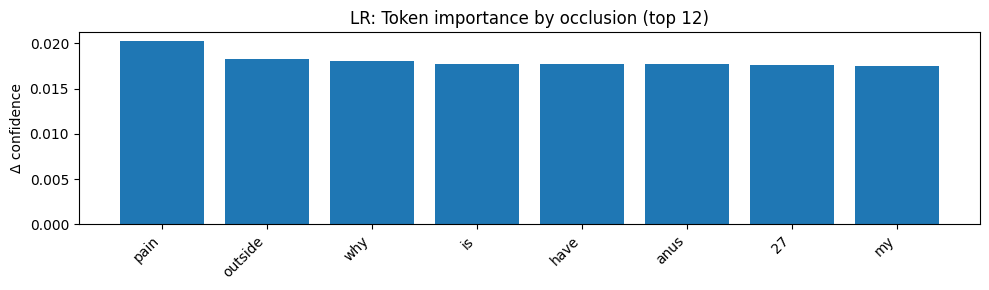


===== SVM Occlusion Explanation =====
Pred class: 1 medium | base_conf: 0.4812


,token,delta_conf
4,pain,0.047846
17,pain,0.047846
23,outside,0.045558
16,have,0.043647
5,inside,0.041582
18,inside,0.041582
24,is,0.041268
22,anus,0.039613
7,anus,0.039613
20,anus,0.038689


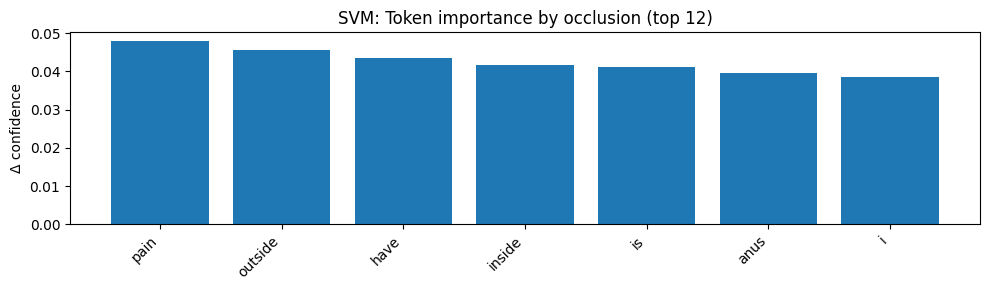


===== NB Occlusion Explanation =====
Pred class: 1 medium | base_conf: 0.7711


,token,delta_conf
23,outside,0.059336
17,pain,0.038380
4,pain,0.038380
5,inside,0.038018
18,inside,0.038018
0,why,0.034468
13,years,0.033413
11,am,0.032336
24,is,0.032233
9,doctor,0.031911


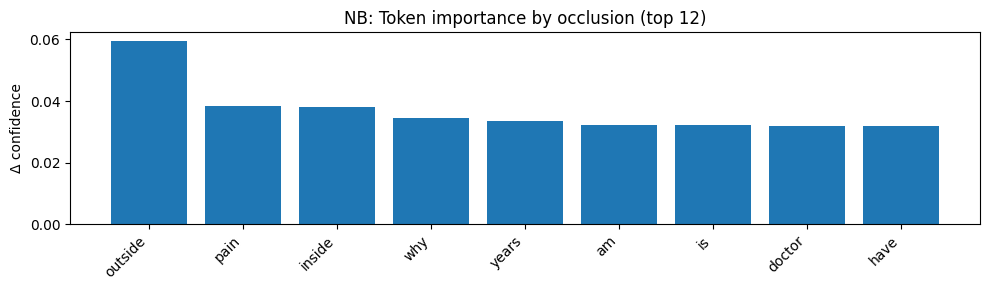


===== FNN Occlusion Explanation =====
Pred class: 1 medium | base_conf: 0.5091


,token,delta_conf
17,pain,0.103272
4,pain,0.103272
7,anus,0.047104
20,anus,0.047104
22,anus,0.047104
13,years,0.037672
9,doctor,0.036932
12,27,0.033512
3,have,0.028254
16,have,0.028254


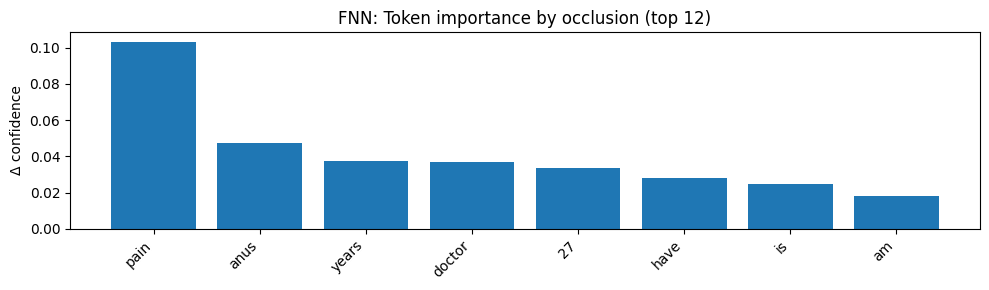


===== BERT Occlusion Explanation =====
Pred class: 1 medium | base_conf: 0.9993


,token,delta_conf
6,my,0.000888
16,have,0.000553
8,hi,0.000437
22,anus,0.000359
2,i,0.000357
11,am,0.000319
14,old,0.000308
15,i,0.000307
24,is,0.000303
10,i,0.000298


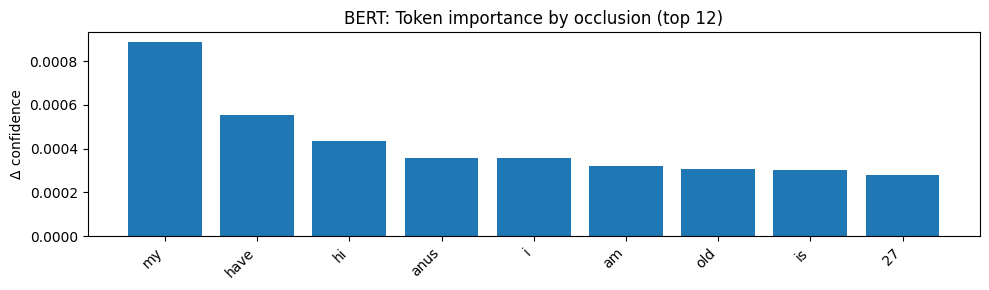

In [ ]:
def softmax_np(scores_2d):
    z = scores_2d - np.max(scores_2d, axis=1, keepdims=True)
    e = np.exp(z)
    return e / np.sum(e, axis=1, keepdims=True)

# ---- proba-like wrappers ----
def proba_lr(texts):
    return lr_pipe.predict_proba(texts)

def proba_nb(texts):
    return nb_pipe.predict_proba(texts)

def proba_svm(texts):
    scores = svm_pipe.decision_function(texts)  # (n, C)
    if scores.ndim == 1:
        scores = np.vstack([-scores, scores]).T
    return softmax_np(scores)

# FNN wrapper (must have glove_vector + torch)
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fnn_model = fnn_model.to(device)

def _glove_vector_safe(text):
    if "glove_vector" in globals():
        return glove_vector(text)
    # fallback
    tokens = str(text).lower().split()
    return np.zeros(100, dtype=np.float32)

def proba_fnn(texts):
    X = np.vstack([_glove_vector_safe(t) for t in texts]).astype(np.float32)
    Xt = torch.tensor(X, dtype=torch.float32).to(device)
    fnn_model.eval()
    with torch.no_grad():
        logits = fnn_model(Xt)
        probs = F.softmax(logits, dim=1).detach().cpu().numpy()
    return probs

# BERT wrapper
bert_src = globals().get("bert_model_final", globals().get("bert_model", None))
if bert_src is None:
    print("[WARN] No bert_model_final/bert_model found for Section 10.3")

def proba_bert(texts, max_len=128):
    bert_src.eval()
    all_probs = []
    with torch.no_grad():
        for t in texts:
            inputs = tokenizer(
                str(t),
                return_tensors="pt",
                truncation=True,
                max_length=max_len
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}
            logits = bert_src(**inputs).logits
            probs = F.softmax(logits, dim=1).detach().cpu().numpy()
            all_probs.append(probs[0])
    return np.vstack(all_probs)

PROBA_FN = {
    "LR": proba_lr,
    "SVM": proba_svm,
    "NB": proba_nb,
    "FNN": proba_fnn,
    "BERT": lambda texts: proba_bert(texts, max_len=128) if bert_src is not None else None
}

def simple_tokens(text, max_tokens=25):
    # tokenization
    toks = re.findall(r"[A-Za-z']+|\d+", str(text).lower())
    return toks[:max_tokens]

def occlusion_explain(model_key, text, max_tokens=25, top_show=15):
    proba_fn = PROBA_FN[model_key]
    if proba_fn is None:
        print(f"[Skip] {model_key}: proba_fn is None")
        return

    toks = simple_tokens(text, max_tokens=max_tokens)
    if len(toks) < 2:
        print(f"[Skip] {model_key}: too few tokens")
        return

    base_probs = proba_fn([text])[0]
    pred = int(np.argmax(base_probs))
    base_conf = float(base_probs[pred])

    drops = []
    for i in range(len(toks)):
        pert = " ".join([t for j, t in enumerate(toks) if j != i])
        p = proba_fn([pert])[0]
        conf_pert = float(p[pred])
        drops.append({
            "token": toks[i],
            "delta_conf": base_conf - conf_pert
        })

    df_imp = pd.DataFrame(drops).sort_values("delta_conf", ascending=False)
    print(f"\n===== {model_key} Occlusion Explanation =====")
    print("Pred class:", pred, _label_name(pred), "| base_conf:", round(base_conf, 4))
    display(df_imp.head(top_show))

    # plot
    plt.figure(figsize=(10, 3))
    plt.bar(df_imp.head(top_show)["token"], df_imp.head(top_show)["delta_conf"])
    plt.xticks(rotation=45, ha="right")
    plt.title(f"{model_key}: Token importance by occlusion (top {top_show})")
    plt.ylabel("Δ confidence")
    plt.tight_layout()
    plt.show()

sample_text = str(test_df.iloc[0][TEXT_COL])
print("\nSample text:", sample_text[:200], "...")

for m in ["LR", "SVM", "NB", "FNN", "BERT"]:
    occlusion_explain(m, sample_text, max_tokens=25, top_show=12)

10.4 # BERT attention visualization (original version + made more robust)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


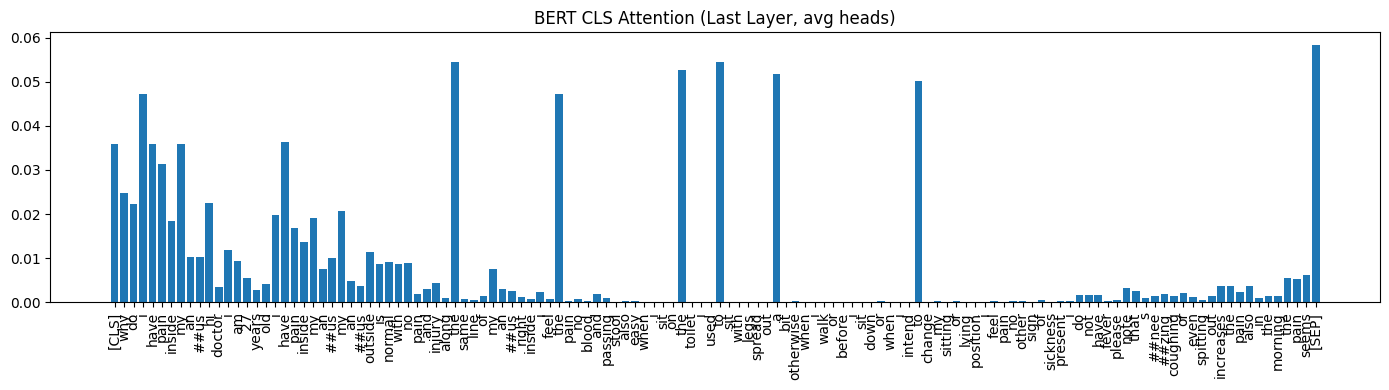

In [ ]:
from transformers import AutoModelForSequenceClassification

if bert_src is not None:
    bert_model_attn = AutoModelForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=3,
        attn_implementation="eager"
    ).to(device)

    bert_model_attn.load_state_dict(bert_src.state_dict(), strict=False)

    def visualize_attention(text, model, tokenizer, max_len=128):
        model.eval()
        inputs = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=max_len
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs, output_attentions=True)
            attentions = outputs.attentions
        if attentions is None:
            raise RuntimeError("attentions is None (check attn_implementation='eager').")

        last = attentions[-1]
        avg_attn = last.mean(dim=1)[0]
        tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].detach().cpu())

        cls_attn = avg_attn[0].detach().cpu().numpy()

        plt.figure(figsize=(14, 4))
        plt.bar(range(len(tokens)), cls_attn)
        plt.xticks(range(len(tokens)), tokens, rotation=90)
        plt.title("BERT CLS Attention (Last Layer, avg heads)")
        plt.tight_layout()
        plt.show()

    # run
    visualize_attention(sample_text, bert_model_attn, tokenizer, max_len=128)
else:
    print("[Skip] BERT attention: no bert model found.")

# **SECTION 11 - BIAS & FAIRNESS**

11.0 Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display
from sklearn.metrics import (
    f1_score, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score
)

# label names
LABEL_NAMES = ["low", "medium", "high"]  # class 0/1/2
y_true = test_df[LABEL_COL].astype(int).to_numpy()

# dynamic pull from globals()
MODEL_SPECS = {
    "LR":   {"pred": "lr_test_pred",   "conf": "lr_test_conf"},
    "SVM":  {"pred": "svm_test_pred",  "conf": "svm_test_conf"},
    "NB":   {"pred": "nb_test_pred",   "conf": "nb_test_conf"},
    "FNN":  {"pred": "fnn_test_pred",  "conf": "fnn_test_conf"},
    "BERT": {"pred": "bert_test_pred", "conf": "bert_test_conf"},
}

preds, confs = {}, {}
missing = []

for m, spec in MODEL_SPECS.items():
    if spec["pred"] in globals():
        preds[m] = np.asarray(globals()[spec["pred"]])
        confs[m] = np.asarray(globals()[spec["conf"]]) if spec["conf"] in globals() else None
    else:
        missing.append(m)

print("Models found:", list(preds.keys()))
if missing:
    print("[WARN] Missing preds for:", missing)

# sanity check length
for m, y_pred in preds.items():
    assert len(y_pred) == len(y_true), f"Length mismatch: {m} pred={len(y_pred)} vs y_true={len(y_true)}"

def metrics_basic(y_t, y_p):
    return {
        "accuracy": float(accuracy_score(y_t, y_p)),
        "macro_f1": float(f1_score(y_t, y_p, average="macro")),
        "macro_precision": float(precision_score(y_t, y_p, average="macro", zero_division=0)),
        "macro_recall": float(recall_score(y_t, y_p, average="macro", zero_division=0)),
    }

Models found: ['LR', 'SVM', 'NB', 'FNN', 'BERT']


11.1 Overall performance (Macro-F1)

,model,macro_f1
4,BERT,0.545308
0,LR,0.522610
1,SVM,0.467086
3,FNN,0.422811
2,NB,0.419425


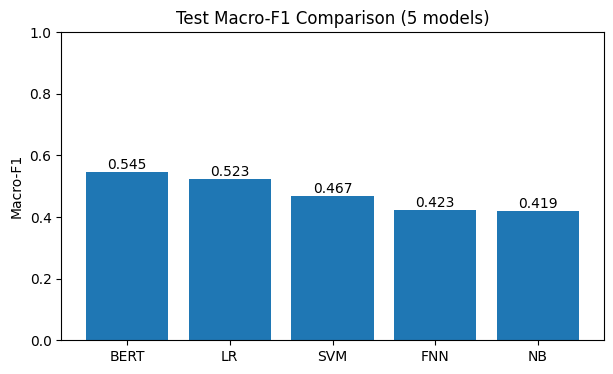

In [ ]:
macro_f1 = {m: f1_score(y_true, y_pred, average="macro") for m, y_pred in preds.items()}
macro_df = pd.DataFrame({"model": list(macro_f1.keys()), "macro_f1": list(macro_f1.values())}) \
             .sort_values("macro_f1", ascending=False)

display(macro_df)

plt.figure(figsize=(7,4))
plt.bar(macro_df["model"], macro_df["macro_f1"])
plt.title("Test Macro-F1 Comparison (5 models)")
plt.ylabel("Macro-F1")
plt.ylim(0, 1)
for i, v in enumerate(macro_df["macro_f1"].values):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center")
plt.show()

11.2 Per-class report

,model,class,support,precision,recall,f1
0,LR,low,161,0.616883,0.590062,0.603175
1,LR,medium,267,0.670833,0.602996,0.635108
2,LR,high,71,0.276190,0.408451,0.329545
3,SVM,low,161,0.646552,0.465839,0.541516
4,SVM,medium,267,0.607450,0.794007,0.688312
5,SVM,high,71,0.264706,0.126761,0.171429
6,NB,low,161,0.623529,0.329193,0.430894
7,NB,medium,267,0.582716,0.883895,0.702381
8,NB,high,71,0.555556,0.070423,0.125000
9,FNN,low,161,0.523560,0.621118,0.568182


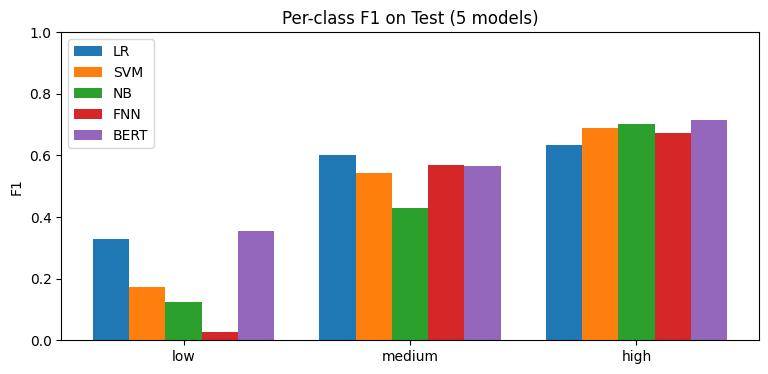

In [ ]:
rows = []
for m, y_pred in preds.items():
    p, r, f1s, sup = precision_recall_fscore_support(
        y_true, y_pred, labels=[0,1,2], zero_division=0
    )
    for cls_i, cls_name in enumerate(LABEL_NAMES):
        rows.append({
            "model": m,
            "class": cls_name,
            "support": int(sup[cls_i]),
            "precision": float(p[cls_i]),
            "recall": float(r[cls_i]),
            "f1": float(f1s[cls_i]),
        })

per_class_df = pd.DataFrame(rows)
display(per_class_df)

# per-class F1 plot (grouped bar)
models = list(preds.keys())
x = np.arange(len(LABEL_NAMES))
width = 0.8 / max(1, len(models))

plt.figure(figsize=(9,4))
for i, m in enumerate(models):
    f1s = per_class_df[per_class_df["model"] == m].sort_values("class")["f1"].values
    plt.bar(x + (i - (len(models)-1)/2)*width, f1s, width, label=m)

plt.xticks(x, LABEL_NAMES)
plt.ylim(0, 1)
plt.ylabel("F1")
plt.title("Per-class F1 on Test (5 models)")
plt.legend()
plt.show()

11.3 Confusion Matrix

<Figure size 500x400 with 0 Axes>

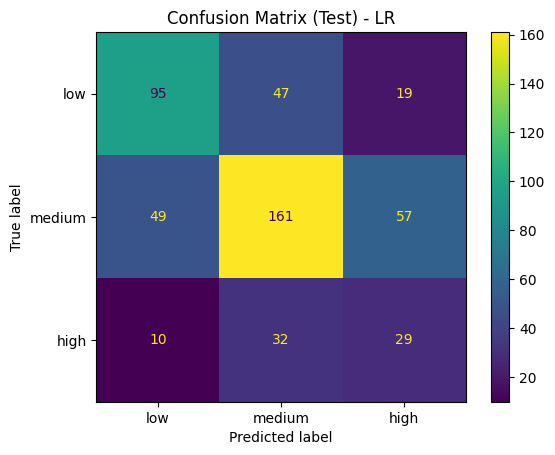

<Figure size 500x400 with 0 Axes>

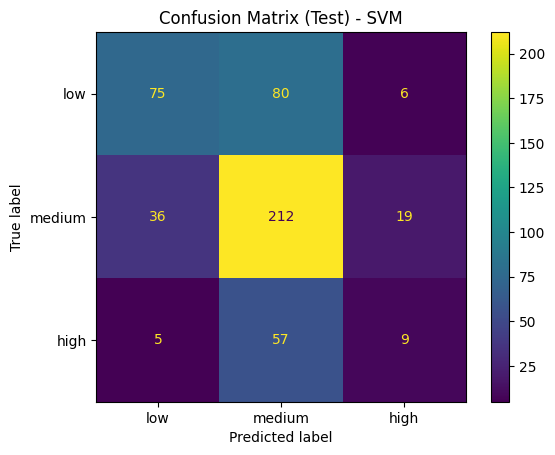

<Figure size 500x400 with 0 Axes>

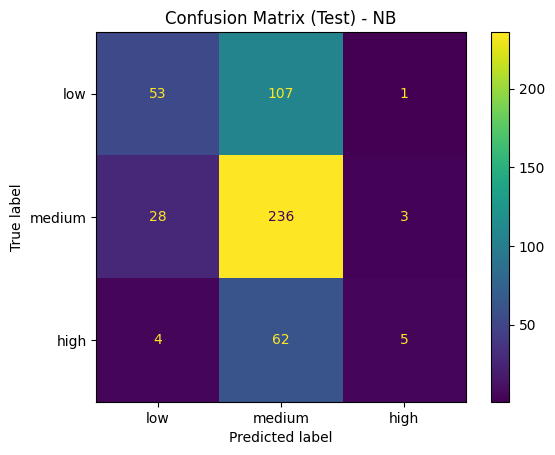

<Figure size 500x400 with 0 Axes>

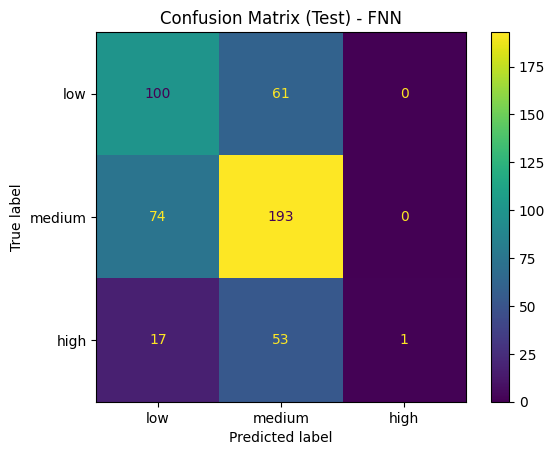

<Figure size 500x400 with 0 Axes>

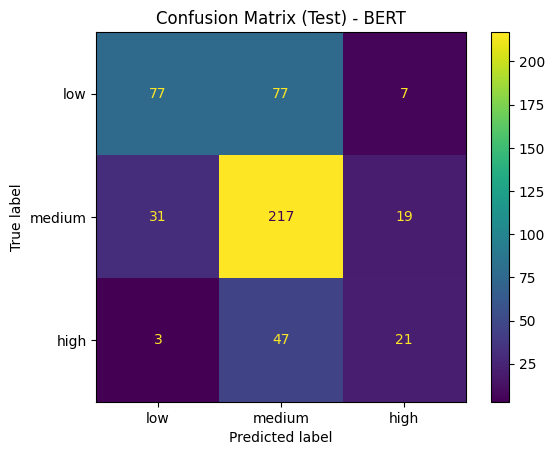

In [ ]:
for m, y_pred in preds.items():
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABEL_NAMES)
    plt.figure(figsize=(5,4))
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix (Test) - {m}")
    plt.show()

11.4 Text length bias

,model,len_bin,n,accuracy,macro_f1,macro_precision,macro_recall
18,BERT,"(104.0, 159.0]",122,0.663934,0.577952,0.597974,0.592179
14,FNN,"(104.0, 159.0]",122,0.688525,0.470912,0.449600,0.497424
2,LR,"(104.0, 159.0]",122,0.655738,0.587002,0.586022,0.640169
10,NB,"(104.0, 159.0]",122,0.655738,0.465038,0.566893,0.455754
6,SVM,"(104.0, 159.0]",122,0.639344,0.491565,0.538969,0.481873
19,BERT,"(159.0, 1003.0]",125,0.656000,0.522574,0.565224,0.502773
15,FNN,"(159.0, 1003.0]",125,0.520000,0.346645,0.318001,0.412775
3,LR,"(159.0, 1003.0]",125,0.488000,0.398480,0.416346,0.392838
11,NB,"(159.0, 1003.0]",125,0.616000,0.390118,0.515344,0.401273
7,SVM,"(159.0, 1003.0]",125,0.592000,0.395032,0.404849,0.399305


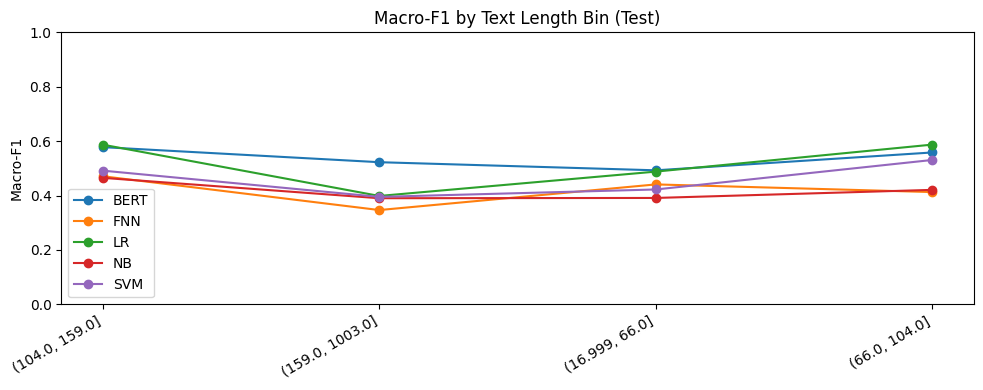

In [ ]:
test_len = test_df[TEXT_COL].astype(str).str.split().apply(len).to_numpy()
bins = pd.qcut(test_len, q=4, duplicates="drop")

bin_df = pd.DataFrame({"len_bin": bins, "text_len": test_len, "y_true": y_true})

for m, y_pred in preds.items():
    bin_df[f"{m}_pred"] = y_pred

# metrics by bin
rows = []
for m in preds.keys():
    for b in sorted(bin_df["len_bin"].unique()):
        sub = bin_df[bin_df["len_bin"] == b]
        met = metrics_basic(sub["y_true"].values, sub[f"{m}_pred"].values)
        rows.append({"model": m, "len_bin": str(b), "n": len(sub), **met})

len_metrics_df = pd.DataFrame(rows)
display(len_metrics_df.sort_values(["len_bin", "model"]))

# plot macro_f1 vs bin
pivot = len_metrics_df.pivot(index="len_bin", columns="model", values="macro_f1")
x = np.arange(len(pivot.index))

plt.figure(figsize=(10,4))
for m in pivot.columns:
    plt.plot(x, pivot[m].values, marker="o", label=m)
plt.xticks(x, pivot.index, rotation=30, ha="right")
plt.ylim(0, 1)
plt.ylabel("Macro-F1")
plt.title("Macro-F1 by Text Length Bin (Test)")
plt.legend()
plt.tight_layout()
plt.show()

11.5 Gender / Age bias (only if detectable)

In [ ]:
import re

age_pat = re.compile(r"\b(\d{1,3})\s*(?:yo|y/o|years?\s*old)\b", re.IGNORECASE)
gender_pat = re.compile(r"\b(male|female|man|woman|boy|girl)\b", re.IGNORECASE)

def extract_age(text):
    m = age_pat.search(str(text))
    return int(m.group(1)) if m else np.nan

def extract_gender(text):
    m = gender_pat.search(str(text))
    return m.group(1).lower() if m else None

test_meta = test_df.copy()
test_meta["age"] = test_meta[TEXT_COL].apply(extract_age)
test_meta["gender_word"] = test_meta[TEXT_COL].apply(extract_gender)
test_meta["y_true"] = y_true

for m, y_pred in preds.items():
    test_meta[f"{m}_pred"] = y_pred

print("Age detected count:", int(test_meta["age"].notna().sum()))
print("Gender word detected count:", int(test_meta["gender_word"].notna().sum()))

def group_metrics_multi(df, group_col):
    rows = []
    for g in df[group_col].dropna().unique():
        sub = df[df[group_col] == g]
        for m in preds.keys():
            met = metrics_basic(sub["y_true"].values, sub[f"{m}_pred"].values)
            rows.append({"group": str(g), "model": m, "n": len(sub), **met})
    return pd.DataFrame(rows)

# age bins
if test_meta["age"].notna().sum() >= 30:
    test_meta["age_bin"] = pd.cut(
        test_meta["age"], bins=[0, 12, 18, 35, 60, 120],
        labels=["child", "teen", "adult", "middle", "senior"]
    )
    age_sub = test_meta.dropna(subset=["age_bin"])
    display(age_sub["age_bin"].value_counts())

    age_metrics = group_metrics_multi(age_sub, "age_bin") \
                    .sort_values(["group", "model"])
    display(age_metrics)
else:
    print("[SKIP] Not enough age signals to analyze reliably.")

# gender word
if test_meta["gender_word"].notna().sum() >= 30:
    gender_sub = test_meta.dropna(subset=["gender_word"])
    display(gender_sub["gender_word"].value_counts())

    gender_metrics = group_metrics_multi(gender_sub, "gender_word") \
                       .sort_values(["group", "model"])
    display(gender_metrics)
else:
    print("[SKIP] Not enough gender signals to analyze reliably.")

Age detected count: 154
Gender word detected count: 89


,count
age_bin,
adult,87
middle,34
senior,15
teen,13
child,5


,group,model,n,accuracy,macro_f1,macro_precision,macro_recall
4,adult,BERT,87,0.655172,0.549383,0.655895,0.523288
3,adult,FNN,87,0.620690,0.430976,0.406847,0.461178
0,adult,LR,87,0.620690,0.486603,0.492861,0.482029
2,adult,NB,87,0.689655,0.450639,0.523909,0.464462
1,adult,SVM,87,0.666667,0.451455,0.478165,0.460239
24,child,BERT,5,0.600000,0.555556,0.555556,0.555556
23,child,FNN,5,0.400000,0.222222,0.222222,0.222222
20,child,LR,5,0.400000,0.388889,0.277778,0.666667
22,child,NB,5,0.800000,0.619048,0.583333,0.666667
21,child,SVM,5,0.600000,0.444444,0.388889,0.555556


,count
gender_word,
male,45
female,30
woman,6
girl,4
boy,2
man,2


,group,model,n,accuracy,macro_f1,macro_precision,macro_recall
19,boy,BERT,2,0.500000,0.333333,0.250000,0.500000
18,boy,FNN,2,0.000000,0.000000,0.000000,0.000000
15,boy,LR,2,0.000000,0.000000,0.000000,0.000000
17,boy,NB,2,0.000000,0.000000,0.000000,0.000000
16,boy,SVM,2,0.000000,0.000000,0.000000,0.000000
9,female,BERT,30,0.433333,0.358752,0.395960,0.366162
8,female,FNN,30,0.633333,0.451389,0.420814,0.486869
5,female,LR,30,0.600000,0.520609,0.525000,0.517677
7,female,NB,30,0.600000,0.380952,0.518519,0.424242
6,female,SVM,30,0.600000,0.405983,0.461111,0.432323


# **SECTION 12 - Computational Cost Analysis**

In [ ]:
import io, time
import numpy as np
import pandas as pd
import joblib

12.1 Helper: safe getter

In [ ]:
def _safe_float(x):
    try:
        return float(x)
    except Exception:
        return None

def get_first_global(names):
    for n in names:
        if n in globals() and globals()[n] is not None:
            return globals()[n]
    return None

def sizeof_joblib_mb(obj):
    try:
        buf = io.BytesIO()
        joblib.dump(obj, buf)
        return float(buf.getbuffer().nbytes / (1024**2))
    except Exception as e:
        print("[WARN] joblib size failed:", e)
        return None

12.2 Torch helpers (FNN/BERT)

In [ ]:
try:
    import torch
    TORCH_OK = True
except Exception as e:
    TORCH_OK = False
    print("[WARN] torch not available -> FNN/BERT cost will be partial:", e)

def count_trainable_params_torch(model):
    if not TORCH_OK or model is None:
        return None
    return int(sum(p.numel() for p in model.parameters() if p.requires_grad))

def sizeof_model_state_dict_mb_torch(model):
    if not TORCH_OK or model is None:
        return None
    total_bytes = 0
    for _, t in model.state_dict().items():
        if torch.is_tensor(t):
            total_bytes += t.numel() * t.element_size()
    return float(total_bytes / (1024**2))


12.3 Inference benchmarks

In [ ]:
def benchmark_sklearn_inference(pipe, texts, n_runs=3):
    # warmup
    _ = pipe.predict(texts[:32])
    times = []
    for _ in range(n_runs):
        t0 = time.perf_counter()
        _ = pipe.predict(texts)
        t1 = time.perf_counter()
        times.append(t1 - t0)
    mean_t = float(np.mean(times))
    return mean_t, float(len(texts) / mean_t)

def benchmark_fnn_inference(fnn_model, texts, batch_size=256, n_runs=3):
    if not TORCH_OK or fnn_model is None:
        return None, None

    # find embedding function
    if "glove_vector" in globals():
        vec_fn = globals()["glove_vector"]
    else:
        def vec_fn(_):
            return np.zeros(100, dtype=np.float32)

    X = np.vstack([vec_fn(t) for t in texts]).astype(np.float32)

    device = next(fnn_model.parameters()).device
    fnn_model.eval()

    def run_once():
        t0 = time.perf_counter()
        with torch.no_grad():
            for i in range(0, len(X), batch_size):
                xb = torch.tensor(X[i:i+batch_size], dtype=torch.float32).to(device)
                _ = fnn_model(xb)
        return time.perf_counter() - t0

    _ = run_once()  # warmup
    times = [run_once() for _ in range(n_runs)]
    mean_t = float(np.mean(times))
    return mean_t, float(len(texts) / mean_t)

def get_bert_model_obj():
    tr = get_first_global(["trainer", "bert_trainer", "bertTrainer", "bert_final_trainer"])
    if tr is not None and hasattr(tr, "model"):
        return tr.model
    return get_first_global(["bert_model", "model_bert", "model", "bertModel"])

def benchmark_bert_inference(tokenizer, bert_model, texts, max_length=256, batch_size=32, n_runs=3):
    if not TORCH_OK or bert_model is None or tokenizer is None:
        return None, None

    device = next(bert_model.parameters()).device
    bert_model.eval()

    def run_once():
        t0 = time.perf_counter()
        with torch.no_grad():
            for i in range(0, len(texts), batch_size):
                batch_texts = texts[i:i+batch_size]
                enc = tokenizer(
                    batch_texts,
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                    max_length=max_length
                ).to(device)
                _ = bert_model(**enc)
        return time.perf_counter() - t0

    _ = run_once()  # warmup
    times = [run_once() for _ in range(n_runs)]
    mean_t = float(np.mean(times))
    return mean_t, float(len(texts) / mean_t)

12.4 Collect training times (Dynamic)

In [ ]:
TRAIN_TIME_KEYS = {
    "LR":   ["LR_TRAIN_TIME_SEC", "lr_train_time_sec", "lr_train_time"],
    "SVM":  ["SVM_TRAIN_TIME_SEC", "svm_train_time_sec", "svm_train_time"],
    "NB":   ["NB_TRAIN_TIME_SEC", "nb_train_time_sec", "nb_train_time"],
    "FNN":  ["FNN_TRAIN_TIME_SEC", "fnn_train_time_sec", "fnn_train_time"],
    "BERT": ["BERT_TRAIN_TIME_SEC", "bert_train_time_sec", "bert_train_time"],
}

train_time = {}
for k, cand in TRAIN_TIME_KEYS.items():
    v = get_first_global(cand)
    train_time[k] = _safe_float(v)

print("=== [DEBUG] Loaded training times (sec) ===")
for k in ["LR","SVM","NB","FNN","BERT"]:
    print(k, "=>", train_time[k])

=== [DEBUG] Loaded training times (sec) ===
LR => 4.462953448999542
SVM => 1.0090705329985212
NB => 0.3279013000010309
FNN => 1.529279647000294
BERT => 490.7961654789997


12.5 Build cost table

In [ ]:
# must have: test_df, TEXT_COL
if "test_df" not in globals():
    raise RuntimeError("not found test_df (run Section split/test 1st)")
if "TEXT_COL" not in globals():
    TEXT_COL = "text_raw"  # fallback

test_texts = test_df[TEXT_COL].astype(str).tolist()

rows = []

# ---- LR ----
if "lr_pipe" in globals():
    lr_pipe = globals()["lr_pipe"]
    lr_clf = lr_pipe.named_steps.get("clf", None)
    lr_params = int(lr_clf.coef_.size + lr_clf.intercept_.size) if hasattr(lr_clf, "coef_") else None
    lr_size_mb = sizeof_joblib_mb(lr_pipe)
    lr_inf_t, lr_sps = benchmark_sklearn_inference(lr_pipe, test_texts, n_runs=3)

    rows.append({
        "model_key": "LR",
        "train_time_sec": train_time["LR"],
        "num_params": lr_params,
        "model_size_mb": lr_size_mb,
        "inf_time_sec": lr_inf_t,
        "samples_per_sec": lr_sps
    })
else:
    print("[WARN] lr_pipe not found -> skip LR in Section 12")

# ---- SVM ----
if "svm_pipe" in globals():
    svm_pipe = globals()["svm_pipe"]
    svm_clf = svm_pipe.named_steps.get("clf", None)
    svm_params = int(svm_clf.coef_.size + svm_clf.intercept_.size) if hasattr(svm_clf, "coef_") else None
    svm_size_mb = sizeof_joblib_mb(svm_pipe)
    svm_inf_t, svm_sps = benchmark_sklearn_inference(svm_pipe, test_texts, n_runs=3)

    rows.append({
        "model_key": "SVM",
        "train_time_sec": train_time["SVM"],
        "num_params": svm_params,
        "model_size_mb": svm_size_mb,
        "inf_time_sec": svm_inf_t,
        "samples_per_sec": svm_sps
    })
else:
    print("[WARN] svm_pipe not found -> skip SVM in Section 12")

# ---- NB ----
if "nb_pipe" in globals():
    nb_pipe = globals()["nb_pipe"]
    nb_clf = nb_pipe.named_steps.get("clf", None)
    nb_params = None
    if hasattr(nb_clf, "feature_log_prob_"):
        nb_params = int(nb_clf.feature_log_prob_.size + getattr(nb_clf, "class_log_prior_", np.array([])).size)
    nb_size_mb = sizeof_joblib_mb(nb_pipe)
    nb_inf_t, nb_sps = benchmark_sklearn_inference(nb_pipe, test_texts, n_runs=3)

    rows.append({
        "model_key": "NB",
        "train_time_sec": train_time["NB"],
        "num_params": nb_params,
        "model_size_mb": nb_size_mb,
        "inf_time_sec": nb_inf_t,
        "samples_per_sec": nb_sps
    })
else:
    print("[WARN] nb_pipe not found -> skip NB in Section 12")

# ---- FNN ----
fnn_model = get_first_global(["fnn_model", "model_fnn"])
if fnn_model is not None and TORCH_OK:
    fnn_params = count_trainable_params_torch(fnn_model)
    fnn_size_mb = sizeof_model_state_dict_mb_torch(fnn_model)
    fnn_inf_t, fnn_sps = benchmark_fnn_inference(fnn_model, test_texts, batch_size=256, n_runs=3)

    rows.append({
        "model_key": "FNN",
        "train_time_sec": train_time["FNN"],
        "num_params": fnn_params,
        "model_size_mb": fnn_size_mb,
        "inf_time_sec": fnn_inf_t,
        "samples_per_sec": fnn_sps
    })
else:
    print("[WARN] fnn_model not found (or torch missing) -> skip FNN in Section 12")

# ---- BERT ----
tokenizer = get_first_global(["tokenizer"])
bert_model = get_bert_model_obj()

if bert_model is not None and tokenizer is not None and TORCH_OK:
    bert_params = count_trainable_params_torch(bert_model)
    bert_size_mb = sizeof_model_state_dict_mb_torch(bert_model)
    bert_inf_t, bert_sps = benchmark_bert_inference(tokenizer, bert_model, test_texts, max_length=256, batch_size=32, n_runs=3)

    rows.append({
        "model_key": "BERT",
        "train_time_sec": train_time["BERT"],
        "num_params": bert_params,
        "model_size_mb": bert_size_mb,
        "inf_time_sec": bert_inf_t,
        "samples_per_sec": bert_sps
    })
else:
    print("[WARN] BERT model/tokenizer not found (or torch missing) -> skip BERT in Section 12")

cost_df = pd.DataFrame(rows)
display(cost_df.sort_values("inf_time_sec", ascending=True))

,model_key,train_time_sec,num_params,model_size_mb,inf_time_sec,samples_per_sec
3,FNN,1.529280,26627,0.101574,0.000464,1.076339e+06
2,NB,0.327901,20058,0.440515,0.034484,1.447052e+04
1,SVM,1.009071,110970,1.682220,0.073881,6.754062e+03
0,LR,4.462953,1114437,19.110523,0.127847,3.903101e+03
4,BERT,490.796165,109484547,417.650402,8.301080,6.011266e+01


# **SECTION 13 - Final Summary + Recommendation**

In [ ]:
import numpy as np
import pandas as pd

if "results_df" not in globals():
    raise RuntimeError("not found results_df (run Section summary section first)")

13.1 Normalize model names -> model_key

In [ ]:
NAME_TO_KEY = {
    "Logistic Regression": "LR",
    "Logistic Regression (TF-IDF)": "LR",
    "LR": "LR",

    "Linear SVM": "SVM",
    "SVM": "SVM",

    "Multinomial NB": "NB",
    "Naive Bayes": "NB",
    "NB": "NB",

    "FNN (GloVe mean)": "FNN",
    "FNN": "FNN",

    "BERT": "BERT",
    "BERT (bert-base-uncased)": "BERT",
}

m = results_df.copy()
m["model_key"] = m["Model"].map(NAME_TO_KEY).fillna(m["Model"])

13.2 Merge: metrics + robustness + cost

In [ ]:
final_df = m.copy()

# robustness
if "robust_summary" in globals():
    rs = robust_summary.copy()
    # robust_summary
    if "model_key" not in rs.columns:
        if "model" in rs.columns:
            rs = rs.rename(columns={"model": "model_key"})
    # rename
    rs = rs.rename(columns={
        "mean_macro_f1": "robust_mean_macro_f1",
        "std_macro_f1": "robust_std_macro_f1"
    })
    final_df = final_df.merge(rs[["model_key","robust_mean_macro_f1","robust_std_macro_f1"]],
                              on="model_key", how="left")
else:
    print("[INFO] robust_summary not found -> skip robustness merge")

# cost
if "cost_df" in globals():
    c = cost_df.copy()
    final_df = final_df.merge(
        c[["model_key","train_time_sec","num_params","model_size_mb","inf_time_sec","samples_per_sec"]],
        on="model_key", how="left"
    )
else:
    print("[INFO] cost_df not found -> skip cost merge")

13.3 Simple efficiency score

In [ ]:
eps = 1e-9
if "inf_time_sec" in final_df.columns:
    final_df["efficiency_f1_per_sec"] = final_df["Macro_F1"] / (final_df["inf_time_sec"] + eps)

display(final_df.sort_values("Macro_F1", ascending=False))

# Auto-pick recommendations
best_perf = final_df.sort_values("Macro_F1", ascending=False).iloc[0]

print("\n====================")
print("SECTION 13 — Recommendation (auto summary)")
print("====================")

print(f"- Best performance (Macro_F1 สูงสุด): {best_perf['Model']} | Macro_F1={best_perf['Macro_F1']:.4f}")

if "inf_time_sec" in final_df.columns and final_df["inf_time_sec"].notna().any():
    best_fast = final_df.sort_values("inf_time_sec", ascending=True).dropna(subset=["inf_time_sec"]).iloc[0]
    print(f"- Fastest inference (บน TEST): {best_fast['Model']} | inf_time_sec={best_fast['inf_time_sec']:.4f} | samples/s={best_fast['samples_per_sec']:.1f}")

if "efficiency_f1_per_sec" in final_df.columns and final_df["efficiency_f1_per_sec"].notna().any():
    best_eff = final_df.sort_values("efficiency_f1_per_sec", ascending=False).dropna(subset=["efficiency_f1_per_sec"]).iloc[0]
    print(f"- Best efficiency (Macro_F1 / sec): {best_eff['Model']} | score={best_eff['efficiency_f1_per_sec']:.4f}")

# robustness line (ถ้ามี)
if "robust_mean_macro_f1" in final_df.columns:
    print("\n[Robustness] mean±std (macro_f1):")
    show_cols = ["Model","robust_mean_macro_f1","robust_std_macro_f1"]
    display(final_df[show_cols].sort_values("robust_mean_macro_f1", ascending=False))

,Model,Accuracy,Macro_F1,Macro_Precision,Macro_Recall,model_key,robust_mean_macro_f1,robust_std_macro_f1,train_time_sec,num_params,model_size_mb,inf_time_sec,samples_per_sec,efficiency_f1_per_sec
4,BERT,0.578313,0.505512,0.528295,0.494542,BERT,0.529662,0.030122,490.796165,109484547,417.650402,8.301080,6.011266e+01,0.060897
0,Logistic Regression,0.540161,0.479090,0.477200,0.481675,LR,0.478952,0.024311,4.462953,1114437,19.110523,0.127847,3.903101e+03,3.747370
1,Linear SVM,0.534137,0.405891,0.424307,0.408701,SVM,0.421986,0.013989,1.009071,110970,1.682220,0.073881,6.754062e+03,5.493809
3,FNN (GloVe mean),0.564257,0.337035,0.385527,0.379198,FNN,0.374628,0.011617,1.529280,26627,0.101574,0.000464,1.076339e+06,726.979498
2,Multinomial NB,0.536145,0.232680,0.178715,0.333333,NB,0.380773,0.025748,0.327901,20058,0.440515,0.034484,1.447052e+04,6.747490



SECTION 13 — Recommendation (auto summary)
- Best performance (Macro_F1 สูงสุด): BERT | Macro_F1=0.5055
- Fastest inference (บน TEST): FNN (GloVe mean) | inf_time_sec=0.0005 | samples/s=1076338.8
- Best efficiency (Macro_F1 / sec): FNN (GloVe mean) | score=726.9795

[Robustness] mean±std (macro_f1):


,Model,robust_mean_macro_f1,robust_std_macro_f1
4,BERT,0.529662,0.030122
0,Logistic Regression,0.478952,0.024311
1,Linear SVM,0.421986,0.013989
2,Multinomial NB,0.380773,0.025748
3,FNN (GloVe mean),0.374628,0.011617


# **SECTION 14 - Visualization Pack (Recommended add-on)**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

14.1 Robustness: mean ± std (errorbar)

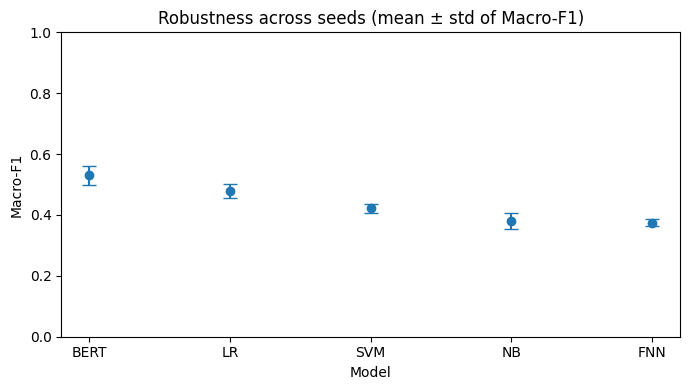

In [ ]:
# requires: robust_summary with columns [model, mean_macro_f1, std_macro_f1]
if "robust_summary" in globals() and isinstance(robust_summary, pd.DataFrame):
    rs = robust_summary.copy()
    # expected cols: model, mean_macro_f1, std_macro_f1
    if {"model","mean_macro_f1","std_macro_f1"}.issubset(rs.columns):
        rs = rs.sort_values("mean_macro_f1", ascending=False)
        plt.figure(figsize=(7,4))
        plt.errorbar(
            rs["model"].astype(str),
            rs["mean_macro_f1"].astype(float),
            yerr=rs["std_macro_f1"].astype(float),
            fmt="o",
            capsize=5
        )
        plt.ylim(0, 1)
        plt.title("Robustness across seeds (mean ± std of Macro-F1)")
        plt.ylabel("Macro-F1")
        plt.xlabel("Model")
        plt.tight_layout()
        plt.show()
    else:
        print("[SKIP] robust_summary found but missing expected columns")
else:
    print("[SKIP] robust_summary not found (run Section 8.5 first)")

14.2 Error Taxonomy: stacked bar (% of errors by category per model)

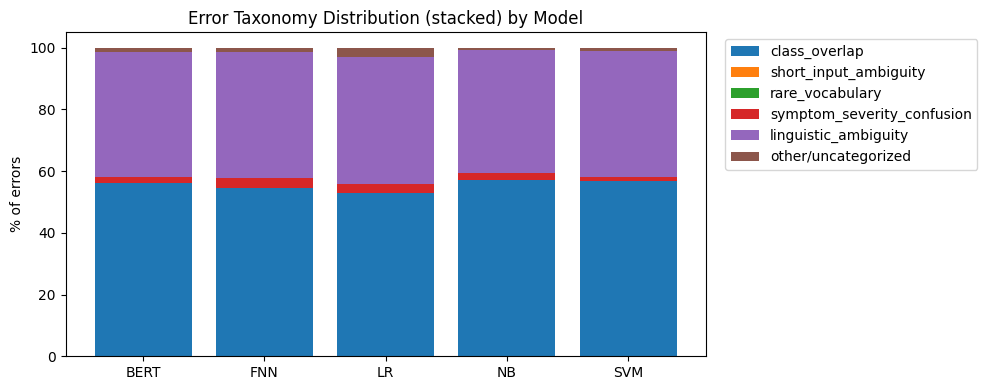

In [ ]:
# requires: summary from Section 9.5 (exploded grouping) with columns:
# [model, categories, pct_of_errors]
if "summary" in globals() and isinstance(summary, pd.DataFrame):
    s = summary.copy()
    if {"model","categories","pct_of_errors"}.issubset(s.columns):
        pivot = s.pivot_table(
            index="model",
            columns="categories",
            values="pct_of_errors",
            aggfunc="sum",
            fill_value=0
        )
        # keep stable category order (optional)
        cat_order = [
            "class_overlap",
            "short_input_ambiguity",
            "rare_vocabulary",
            "symptom_severity_confusion",
            "linguistic_ambiguity",
            "other/uncategorized"
        ]
        cols = [c for c in cat_order if c in pivot.columns] + [c for c in pivot.columns if c not in cat_order]
        pivot = pivot[cols]

        # stacked bar
        plt.figure(figsize=(10,4))
        bottom = np.zeros(len(pivot))
        x = np.arange(len(pivot.index))
        for c in pivot.columns:
            vals = pivot[c].values
            plt.bar(x, vals, bottom=bottom, label=str(c))
            bottom += vals

        plt.xticks(x, pivot.index.astype(str))
        plt.ylabel("% of errors")
        plt.title("Error Taxonomy Distribution (stacked) by Model")
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.tight_layout()
        plt.show()
    else:
        print("[SKIP] summary found but missing expected columns")
else:
    print("[SKIP] summary not found (run Section 9.5 first)")

14.3 Cost vs Performance: scatter

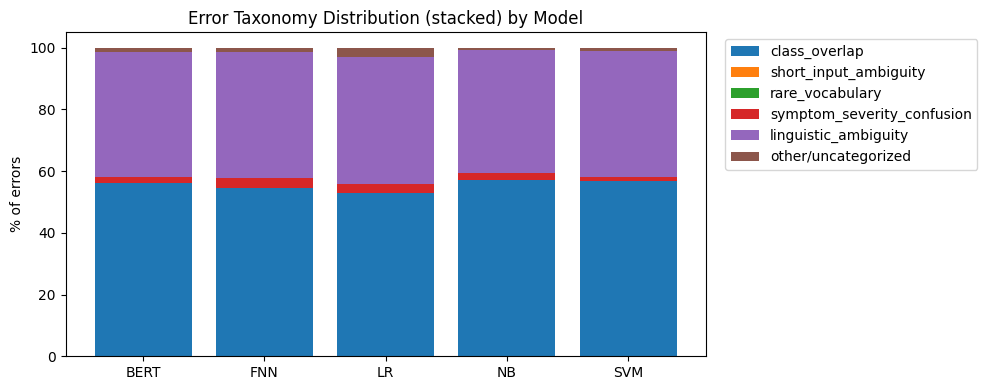

In [ ]:
# requires: summary from Section 9.5 (exploded grouping) with columns:
# [model, categories, pct_of_errors]
if "summary" in globals() and isinstance(summary, pd.DataFrame):
    s = summary.copy()
    if {"model","categories","pct_of_errors"}.issubset(s.columns):
        pivot = s.pivot_table(
            index="model",
            columns="categories",
            values="pct_of_errors",
            aggfunc="sum",
            fill_value=0
        )
        # keep stable category order (optional)
        cat_order = [
            "class_overlap",
            "short_input_ambiguity",
            "rare_vocabulary",
            "symptom_severity_confusion",
            "linguistic_ambiguity",
            "other/uncategorized"
        ]
        cols = [c for c in cat_order if c in pivot.columns] + [c for c in pivot.columns if c not in cat_order]
        pivot = pivot[cols]

        # stacked bar
        plt.figure(figsize=(10,4))
        bottom = np.zeros(len(pivot))
        x = np.arange(len(pivot.index))
        for c in pivot.columns:
            vals = pivot[c].values
            plt.bar(x, vals, bottom=bottom, label=str(c))
            bottom += vals

        plt.xticks(x, pivot.index.astype(str))
        plt.ylabel("% of errors")
        plt.title("Error Taxonomy Distribution (stacked) by Model")
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.tight_layout()
        plt.show()
    else:
        print("[SKIP] summary found but missing expected columns")
else:
    print("[SKIP] summary not found (run Section 9.5 first)")

# **SECTION 15 - BACKUP: export tables + save models + zip + download**

In [ ]:
import os, json, zipfile, shutil
import numpy as np
import pandas as pd

OUT_DIR = "pj_nlp_backup"
TABLE_DIR = os.path.join(OUT_DIR, "tables")
MODEL_DIR = os.path.join(OUT_DIR, "models")

# reset folder
if os.path.isdir(OUT_DIR):
    shutil.rmtree(OUT_DIR)
os.makedirs(TABLE_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

15.1 Export tables (DataFrames) -> CSV

In [ ]:
DENY_NAMES = {
    "df", "train_df", "val_df", "test_df", "temp_df", "trainval_df", "FULL_DF"
}

saved_tables = []
for name, obj in list(globals().items()):
    if isinstance(obj, pd.DataFrame):
        if name in DENY_NAMES:
            continue
        if name.endswith("_df") or name in {"summary","errors_all","final_df","macro_df","per_class_df","len_metrics_df","ttest_df","robust_summary"}:
            path = os.path.join(TABLE_DIR, f"{name}.csv")
            obj.to_csv(path, index=False)
            saved_tables.append({"name": name, "path": path, "shape": list(obj.shape)})

print(f"Saved tables: {len(saved_tables)}")
for t in saved_tables[:10]:
    print(" -", t["name"], t["shape"])

Saved tables: 22
 - eda_df [3, 4]
 - ablation_df [4, 4]
 - results_df [5, 5]
 - tuned_ml_df [3, 5]
 - fnn_tune_df [36, 5]
 - bert_tune_df [4, 6]
 - tr_df [2323, 8]
 - va_df [498, 8]
 - te_df [499, 8]
 - robust_df [5, 7]


15.2 Save configs/metadata -> JSON

In [ ]:
meta = {
    "CONFIG": globals().get("CONFIG", None),
    "BEST_LR_PARAMS": globals().get("BEST_LR_PARAMS", None),
    "BEST_SVM_PARAMS": globals().get("BEST_SVM_PARAMS", None),
    "BEST_NB_PARAMS": globals().get("BEST_NB_PARAMS", None),
    "FNN_CONFIG": globals().get("FNN_CONFIG", None),
    "BEST_BERT": globals().get("BEST_BERT", None),
    "SEEDS": globals().get("SEEDS", None),
}
with open(os.path.join(TABLE_DIR, "metadata.json"), "w") as f:
    json.dump(meta, f, indent=2)

print("Saved metadata.json")

Saved metadata.json


15.3 Save models

In [ ]:
import joblib

def try_joblib_dump(obj, out_path):
    try:
        joblib.dump(obj, out_path)
        print("Saved:", out_path)
    except Exception as e:
        print("[WARN] joblib dump failed:", out_path, "|", e)

if "lr_pipe" in globals():
    try_joblib_dump(lr_pipe, os.path.join(MODEL_DIR, "LR_pipe.joblib"))
if "svm_pipe" in globals():
    try_joblib_dump(svm_pipe, os.path.join(MODEL_DIR, "SVM_pipe.joblib"))
if "nb_pipe" in globals():
    try_joblib_dump(nb_pipe, os.path.join(MODEL_DIR, "NB_pipe.joblib"))

# (B) FNN (PyTorch) -> state_dict + config
try:
    import torch
    TORCH_OK = True
except Exception:
    TORCH_OK = False

if TORCH_OK and "fnn_model" in globals():
    fnn_dir = os.path.join(MODEL_DIR, "FNN")
    os.makedirs(fnn_dir, exist_ok=True)
    torch.save(fnn_model.state_dict(), os.path.join(fnn_dir, "fnn_state_dict.pt"))
    with open(os.path.join(fnn_dir, "fnn_config.json"), "w") as f:
        json.dump(globals().get("FNN_CONFIG", {}), f, indent=2)
    print("Saved: FNN state_dict + config")

# (C) BERT (HF) -> save_pretrained (model + tokenizer)
def get_bert_model_obj():
    if "bert_model_final" in globals() and globals()["bert_model_final"] is not None:
        return globals()["bert_model_final"]
    if "bert_model" in globals() and globals()["bert_model"] is not None:
        return globals()["bert_model"]
    if "bert_trainer" in globals() and hasattr(bert_trainer, "model"):
        return bert_trainer.model
    if "trainer" in globals() and hasattr(trainer, "model"):
        return trainer.model
    return None

bert_obj = get_bert_model_obj()
tok_obj = globals().get("tokenizer", None)

if bert_obj is not None and tok_obj is not None:
    bert_dir = os.path.join(MODEL_DIR, "BERT")
    os.makedirs(bert_dir, exist_ok=True)
    try:
        bert_obj.save_pretrained(bert_dir)
        tok_obj.save_pretrained(bert_dir)
        print("Saved: BERT save_pretrained (model + tokenizer)")
    except Exception as e:
        print("[WARN] BERT save_pretrained failed:", e)
else:
    print("[WARN] BERT model/tokenizer not found -> skip BERT saving")


Saved: pj_nlp_backup/models/LR_pipe.joblib
Saved: pj_nlp_backup/models/SVM_pipe.joblib
Saved: pj_nlp_backup/models/NB_pipe.joblib
Saved: FNN state_dict + config


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Saved: BERT save_pretrained (model + tokenizer)


15.4 Save all figures (Matplotlib)

In [ ]:
import os
import matplotlib.pyplot as plt

FIG_DIR = os.path.join(OUT_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

fig_nums = plt.get_fignums()
print("Matplotlib figures in memory:", fig_nums)

saved_figs = []
for idx, num in enumerate(fig_nums, start=1):
    fig = plt.figure(num)
    png_path = os.path.join(FIG_DIR, f"fig_{idx:02d}.png")
    pdf_path = os.path.join(FIG_DIR, f"fig_{idx:02d}.pdf")
    try:
        fig.savefig(png_path, dpi=200, bbox_inches="tight")
        fig.savefig(pdf_path, bbox_inches="tight")
        saved_figs.append((png_path, pdf_path))
    except Exception as e:
        print(f"[WARN] Save figure {num} failed:", e)

print(f"Saved figures: {len(saved_figs)}")
if len(saved_figs) > 0:
    print("Example:", saved_figs[0])

Matplotlib figures in memory: []
Saved figures: 0


15.4 Zip everything

In [ ]:
ZIP_PATH = "pj_nlp_backup.zip"
with zipfile.ZipFile(ZIP_PATH, "w", zipfile.ZIP_DEFLATED) as z:
    for root, _, files in os.walk(OUT_DIR):
        for fn in files:
            full = os.path.join(root, fn)
            arc = os.path.relpath(full, OUT_DIR)
            z.write(full, arcname=arc)

print("Created zip:", ZIP_PATH)

Created zip: pj_nlp_backup.zip


15.5 Download (Colab) / Local note

In [ ]:
try:
    from google.colab import files
    files.download(ZIP_PATH)
except Exception as e:
    print("[INFO] Not running in Colab. Download manually from:", os.path.abspath(ZIP_PATH))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>